Лабораторная работа 3. Классификация. Нейронные сети

Цель работы: изучение методов классификации данных, реализованные в библиотеке Scikit-Learn, а также ознакомление с нейронными сетями с использованием библиотек TensorFlow и TensorBoard.

Задачи:
1. Выбрать датасет, описать информацию о выбранном датасете, характеризовать признаки, провести предобработку данных.

2. Разбить данные на обучающий и тестовый наборы.

3. Построить классификационные модели с помощью пяти методов:

- наивный Байесовский классификатор (GaussianNB, MultinomialNB, ComplementNB, BernoulliNB);

- деревья решений (Decision Tree);

- линейный дискриминантный анализ (Linear Discriminant Analysis);

- метод опорных векторов (Support Vector Machines);

- метод ближайших соседей (k-Nearest Neighbors).

4. Сравнить качество работы классификаторов с помощью следующих метрик:

- accuracy (точность),

- precision (доля правильно классифицированных положительных примеров),

- recall (чувствительность, доля верно найденных положительных примеров),

- F1-Score (среднее гармоническое precision и recall),

- площадь под кривой ROC (AUC-ROC).

5. Настроить гиперпараметры каждого метода и провести исследование влияния различных параметров на качество классификации.

6. Реализовать и протестировать нейронную сеть на TensorFlow, исследовать эффект настройки гиперпараметров и визуализировать процесс обучения с помощью инструмента TensorBoard.

Выбранный датасет: Stellar Classification Dataset: Классификация звёзд, галактик и квазаров. <br> <br>
Описание датасета: данные состоят из 100000 наблюдений за космосом, сделанных в рамках проекта SDSS (Sloan Digital Sky Survey). Каждое наблюдение описывается 17 столбцами с характеристиками и 1 столбцом с классом, который определяет, является ли объект звездой, галактикой или квазаром.

Столбцы в датасете: <br>
obj_ID = идентификатор объекта, уникальное значение, которое идентифицирует объект в каталоге изображений, используемом CAS <br>
alpha = угол прямого восхождения (в эпоху J2000) <br>
delta = угол склонения (в эпоху J2000) <br>
u = ультрафиолетовый фильтр в фотометрической системе <br>
g = зелёный фильтр в фотометрической системе<br>
r = красный фильтр в фотометрической системе<br>
i = фильтр ближнего инфракрасного диапазона в фотометрической системе<br>
z = инфракрасный фильтр в фотометрической системе<br>
run_ID = номер запуска, используемый для идентификации конкретного сканирования<br>
rereun_ID = номер повторного запуска, указывающий на способ обработки изображения<br>
cam_col = столбец камеры для определения строки сканирования в прогоне<br>
field_ID = номер поля для идентификации каждого поля<br>
spec_obj_ID = уникальный идентификатор, используемый для оптических спектроскопических объектов<br>
**class** = **целевая переменная**, объект класса (галактика, звезда или квазар)<br>
redshift = значение красного смещения, основанное на увеличении длины волны<br>
plate = идентификатор пластины, уникальный для каждой пластины в SDSS<br>
MJD = модифицированная юлианская дата, используемая для обозначения времени получения данных SDSS<br>
fiber_ID = идентификатор волокна, который определяет волокно, направляющее свет в фокальную плоскость при каждом наблюдении<br>

1. Загрузка данных <br>

В исходном датасете 100000 значений, было взято 9999 для анализа (была проведена балансировка - отбор значений датасета таким образом, что в результате к каждому классу принадлежит равное количество)

In [176]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.preprocessing import Binarizer, LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report
)
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import TensorBoard
import keras_tuner as kt
import datetime
import os


df = pd.read_csv('star_classification.csv')
df = df.replace('?', pd.NA).dropna()

samples_per_class = 3333  
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_dfs = []
for class_name in df_shuffled['class'].unique():
    class_subset = df_shuffled[df_shuffled['class'] == class_name].head(samples_per_class)
    balanced_dfs.append(class_subset)
    
df_balanced = pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)
print(df_balanced['class'].value_counts())
df = df_balanced

columns_to_drop = ['obj_ID', 'run_ID', 'rerun_ID', 
                   'field_ID', 'spec_obj_ID', 'fiber_ID',
                   'plate', 'MJD']
df = df.drop(columns=columns_to_drop)
print(f"Размер: {df.shape}")
print(df.describe())


class
STAR      3333
QSO       3333
GALAXY    3333
Name: count, dtype: int64
Размер: (9999, 10)
             alpha        delta            u            g            r  \
count  9999.000000  9999.000000  9999.000000  9999.000000  9999.000000   
mean    178.277087    24.642663    21.761594    20.495187    19.719896   
std      97.965607    19.769580     2.166039     1.965812     1.827624   
min       0.013337   -17.284791    10.996230    10.511390    10.068540   
25%     124.825200     5.165229    20.208780    19.095570    18.457365   
50%     181.692764    24.962180    21.753680    20.874980    20.187320   
75%     236.416362    40.877418    23.233580    21.860610    21.097950   
max     359.999810    82.947622    29.234380    26.881750    27.397090   

                 i            z      cam_col     redshift  
count  9999.000000  9999.000000  9999.000000  9999.000000  
mean     19.277994    19.013666     3.509951     0.705991  
std       1.777786     1.796208     1.584417     0.900599

2. Подсчёт значений ассиметрии, эксцесса и моды

In [177]:
numeric_columns = df.select_dtypes(include=[np.number]).columns

print("\nАсимметрия:")
for col in numeric_columns:
    skew_val = skew(df[col].dropna())
    print(f"{col:20s}: {skew_val:8.3f}")

print("\nЭксцесс:")
for col in numeric_columns:
    kurt_val = kurtosis(df[col].dropna())
    print(f"{col:20s}: {kurt_val:8.3f}")

print("\nМода:")
for col in numeric_columns:
    mode_value = df[col].mode()
    print(f"{col:20s}: {mode_value.iloc[0]}")


Асимметрия:
alpha               :   -0.012
delta               :    0.125
u                   :    0.012
g                   :   -0.424
r                   :   -0.650
i                   :   -0.551
z                   :   -0.463
cam_col             :   -0.027
redshift            :    1.788

Эксцесс:
alpha               :   -0.616
delta               :   -1.099
u                   :   -0.283
g                   :   -0.077
r                   :   -0.054
i                   :   -0.062
z                   :   -0.190
cam_col             :   -1.114
redshift            :    4.640

Мода:
alpha               : 0.0133366618319997
delta               : -17.2847913705915
u                   : 24.63465
g                   : 16.82076
r                   : 20.54841
i                   : 19.64404
z                   : 22.8269
cam_col             : 4
redshift            : 0.0


3. Построение гистограмм распределений признаков

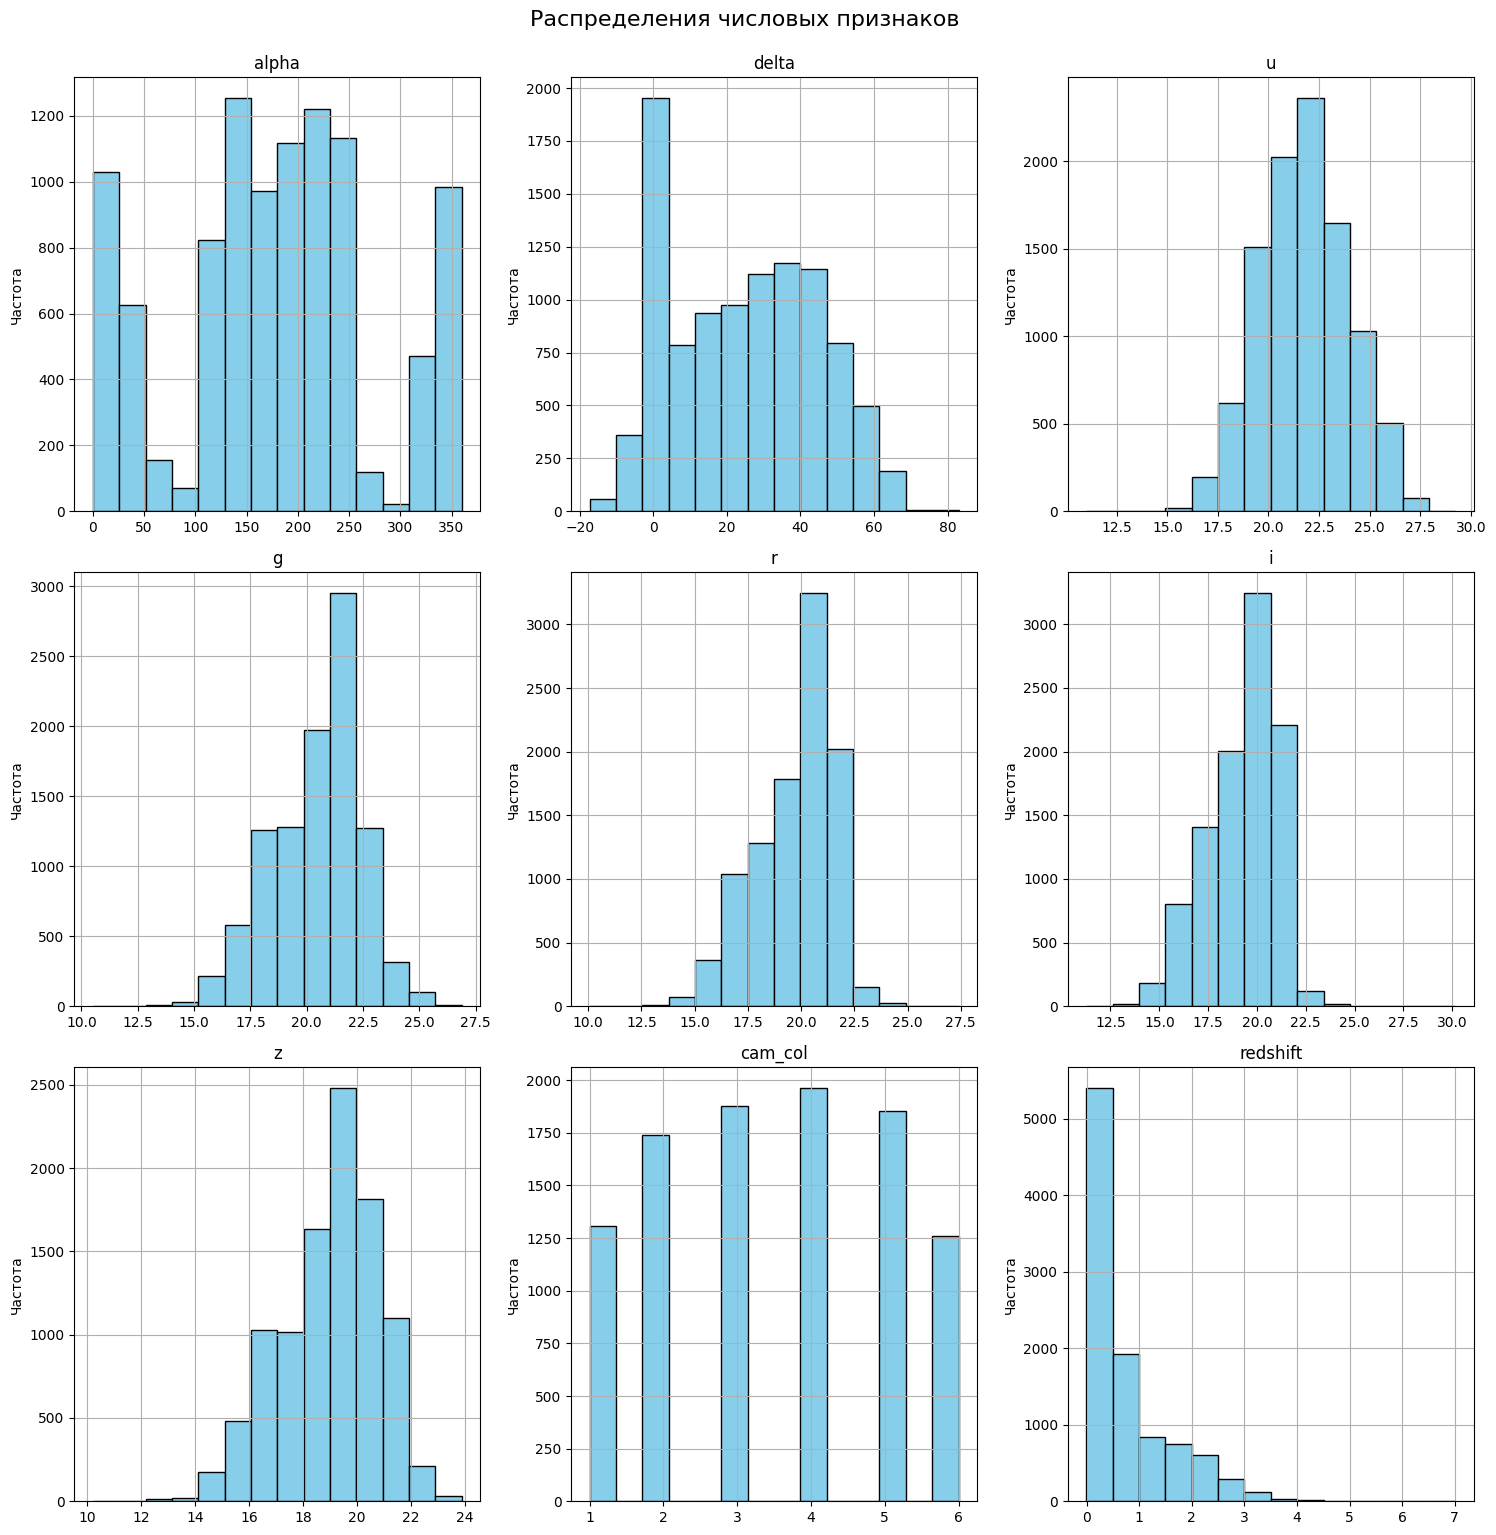

In [178]:
count_intervals = int(1 + math.log2(df.shape[0]))

n_features = len(numeric_columns)
n_subplot_cols = 3
n_subplot_rows = math.ceil(n_features / n_subplot_cols)  
fig, axes = plt.subplots(n_subplot_rows, n_subplot_cols, figsize=(15, 5 * n_subplot_rows))
axes = axes.flatten() if n_subplot_rows > 1 else axes  
for i, col in enumerate(numeric_columns):
    df[col].hist(bins=count_intervals, ax=axes[i], 
                 color='skyblue', edgecolor='black')
    axes[i].set_title(col)  
    axes[i].set_ylabel('Частота')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.suptitle("Распределения числовых признаков", y=1.02, fontsize=16)
plt.show()

1. alpha <br>
Асимметрия: -0.012 => почти симметрично<br>
Эксцесс: -0.616 => плосковершинное <br>

Распределение близко к равномерному (видно по гистограмме — пики в начале и конце, падение в середине), слабо асимметрично.

2. delta<br>
Мин/макс: -17.28 – 82.95 => несимметричный диапазон<br>
Асимметрия: 0.125 => слабый сдвиг вправо<br>
Эксцесс: -1.099 => очень плоское распределение<br>

Распределение плоское, с небольшим сдвигом вправо. Гистограмма показывает пик в районе 0–20. 

3. u <br>
Асимметрия: 0.012 => почти симметрично<br>
Эксцесс: -0.283 => слегка плоское<br>

Распределение почти симметричное, но с небольшим хвостом в сторону ярких объектов (левый хвост). Гистограмма показывает пик около 22.

4. g<br>
Асимметрия: -0.424 => сильный сдвиг влево<br>
Эксцесс: -0.077 => почти нормальное<br>

Сильно скошено влево — преобладание зеленого фильтра. Мода (16.82) гораздо ниже среднего (20.49), что указывает на наличие большого количества ярких источников. 

5. r<br>
Асимметрия: -0.650 => очень сильный сдвиг влево<br>
Эксцесс: -0.054 => почти нормальное<br>
Мода: 20.55 => близко к медиане<br>

Ещё более выраженный левый хвост, чем у g. 

6. i 
Асимметрия: -0.551 => сильный сдвиг влево<br>
Эксцесс: -0.062 => почти нормальное<br>
Мода: 19.64 => близко к среднему<br>

Похоже на r и g — сильный левый хвост. Гистограмма подтверждает: пик около 20, но есть длинный хвост влево. 

7. z 
Асимметрия: -0.463 => умеренный сдвиг влево<br>
Эксцесс: -0.190 => слегка плоское<br>

Менее скошено, чем r и i. Хвост влево менее выражен. 

8. cam_col (категориальный признак)<br>
Тип: целые числа от 1 до 6<br>
Асимметрия: -0.027 => почти симметрично<br>
Эксцесс: -1.114 => плоское распределение<br>

Данный признак будет обработан как категориальный.

9. redshift <br>
Мин/макс: -0.004 – 7.01 => довольно широкий диапазон<br>
Асимметрия: 1.788 => очень сильный сдвиг вправо<br>
Эксцесс: 4.64 => очень островершинное<br>

Распределение сильно скошено вправо, имеет ярко выраженный пик в 0. 

4. Предобработка данных (стандартизация числовых признаков, обработка категориального признака с помощью OneHotEncoder)

In [179]:
le = LabelEncoder()
df['class_num'] = le.fit_transform(df['class'])
columns_to_drop = ['class']
df = df.drop(columns=columns_to_drop)

X = df.drop('class_num', axis=1)  
y = df['class_num']

numeric_features = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift']
categorical_features = ['cam_col']  

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features) 
    ]
)

X_processed = preprocessor.fit_transform(X)

Матрица ошибок (Confusion Matrix) — это таблица размером n на n, где n — количество классов. В строках указываются истинные метки классов, в столбцах — предсказанные моделью метки. Ячейка на пересечении строки i и столбца j содержит количество экземпляров, которые принадлежат истинному классу i, но были предсказаны как класс j. Сумма всех значений в матрице равна общему количеству экземпляров в выборке.

Из матрицы ошибок можно извлечь значения TP, TN, FP, FN для каждого класса отдельно, рассматривая его как "положительный", а все остальные — как "отрицательные".

Метрики для оценки качества моделей: <br>
1. Accuracy (Точность)<br>
Общая доля правильных предсказаний по всем классам. <br>
Формула: Accuracy = (Сумма диагональных элементов матрицы ошибок) / (Общее количество экземпляров)

2.	Precision (Точность) для класса i<br>
Доля правильных предсказаний конкретного класса i среди всех экземпляров, предсказанных как этот класс. <br>
Формула: Precision_i = TP_i / (TP_i + FP_i), где <br> TP_i — количество экземпляров класса i, правильно предсказанных как i (диагональный элемент), <br> FP_i — количество экземпляров других классов, ошибочно предсказанных как i (сумма по столбцу i, за исключением диагонального элемента).
 
3.	Recall (Полнота) для класса i<br>
Доля экземпляров класса i, правильно предсказанных как i, среди всех реальных экземпляров класса i. <br>
Формула: Recall_i = TP_i / (TP_i + FN_i), 
где <br>FN_i — количество экземпляров класса i, ошибочно предсказанных как другие классы (сумма по строке i, за исключением диагонального элемента).

4.	F1-Score (Среднее гармоническое между Precision и Recall)<br>
Сбалансированная метрика, учитывает как точность, так и полноту для конкретного класса. <br>
Формула: F1_i = 2 * (Precision_i * Recall_i) / (Precision_i + Recall_i)

5. AUC-ROC (Area Under the ROC Curve) — это метрика, оценивающая способность модели различать классы. Она рассчитывается отдельно для каждого класса. Для каждого класса строится бинарная задача: этот класс против всех остальных. Для каждого класса i вычисляется его собственная кривая ROC, используя вероятности принадлежности к классу i. По оси X откладывается False Positive Rate (доля неправильно классифицированных отрицательных примеров) для класса i, по оси Y — True Positive Rate (TPR, или Recall) для класса i. Затем вычисляется AUC для каждой из этих кривых.
- AUC = 1 означает, что модель идеально разделяет классы.
- AUC = 0.5 означает, что модель не лучше, чем случайное угадывание (это соответствует диагональной линии на графике ROC). <br>
Чем ближе AUC к 1, тем лучше модель различает классы.

<br>
Микро- и макроусреднение это два способа усреднения метрик (таких как precision, recall и F1-score) по всем классам в задаче многоклассовой классификации. <br>
Micro-averaging (микроусреднение): метрики считаются глобально, суммируются все значения TP, FP, TN, FN для всех классов, а затем вычисляется метрика.<br>
Macro-averaging (макроусреднение): метрики считаются для каждого класса отдельно, а затем усредняются, что даёт равный вес каждому классу, независимо от его размера в выборке.

5. Наивный Байесовский классификатор (GaussianNB) - гиперпараметры по умолчанию <br>

Наивный Байесовский классификатор (GaussianNB) — это вероятностная модель машинного обучения, основанная на теореме Байеса с предположением о независимости признаков. Конкретно GaussianNB предполагает, что признаки внутри каждого класса распределены по нормальному (гауссовому) закону. Он вычисляет вероятность принадлежности объекта к каждому классу, используя это предположение, и выбирает класс с наибольшей вероятностью. <br>

Выборка разделяется на обучающее и тестовое множество в соотношении 80:20

Наивный Байесовский классификатор (GaussianNB, default)
=== Метрики для обучающего множества ===
Accuracy: 0.9212
Precision (macro): 0.9215
Precision (micro): 0.9212
Recall (macro): 0.9209
Recall (micro): 0.9212
F1-score (macro): 0.9208
F1-score (micro): 0.9212
AUC (macro, ovr): 0.9795
------------------------------
=== Метрики для тестового множества ===
Accuracy: 0.9245
Precision (macro): 0.9256
Precision (micro): 0.9245
Recall (macro): 0.9258
Recall (micro): 0.9245
F1-score (macro): 0.9256
F1-score (micro): 0.9245
AUC (macro, ovr): 0.9780
------------------------------

Classification Report (test):
              precision    recall  f1-score   support

           0     0.9005    0.8737    0.8869       673
           1     0.8917    0.9099    0.9007       688
           2     0.9845    0.9937    0.9891       639

    accuracy                         0.9245      2000
   macro avg     0.9256    0.9258    0.9256      2000
weighted avg     0.9243    0.9245    0.9243      2000



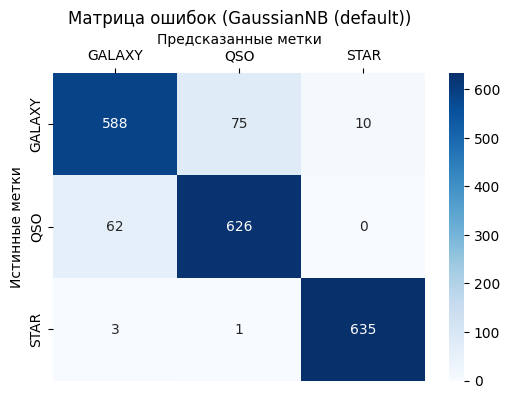

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_train_pred = gnb.predict(X_train)
y_test_pred = gnb.predict(X_test)
y_train_proba = gnb.predict_proba(X_train)
y_test_proba = gnb.predict_proba(X_test)


results = []

def calculate_metrics(y_true, y_pred, y_proba, dataset_name):
    print(f"=== Метрики для {dataset_name} ===")
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_true, y_pred, average='micro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_true, y_pred, average='micro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    auc = roc_auc_score(y_true, y_proba, average='macro', multi_class='ovr')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision_macro:.4f}")
    print(f"Precision (micro): {precision_micro:.4f}")
    print(f"Recall (macro): {recall_macro:.4f}")
    print(f"Recall (micro): {recall_micro:.4f}")
    print(f"F1-score (macro): {f1_macro:.4f}")
    print(f"F1-score (micro): {f1_micro:.4f}")
    print(f"AUC (macro, ovr): {auc:.4f}")
    print("-" * 30)

    return {
        'Accuracy': accuracy,
        'Precision (macro)': precision_macro,
        'Precision (micro)': precision_micro,
        'Recall (macro)': recall_macro,
        'Recall (micro)': recall_micro,
        'F1-score (macro)': f1_macro,
        'F1-score (micro)': f1_micro,
        'AUC (macro, ovr)': auc
    }

print('Наивный Байесовский классификатор (GaussianNB, default)')
calculate_metrics(y_train, y_train_pred, y_train_proba, "обучающего множества")

results.append({
    'Model': 'GaussianNB (default)',
    'Dataset': 'Test',
    **calculate_metrics(y_test, y_test_pred, y_test_proba, "тестового множества")
})

print("\nClassification Report (test):")
print(classification_report(y_test, y_test_pred, digits=4))


y_test_generic = y_test  
y_pred_generic = y_test_pred 
model_name = "GaussianNB (default)" 
label_encoder = le
cm = confusion_matrix(y_test_generic, y_pred_generic)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xticks(rotation=0)  
plt.gca().xaxis.tick_top() 
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title(f'Матрица ошибок ({model_name})')
plt.show()

6. Наивный Байесовский классификатор (GaussianNB) - подбор гиперпараметров <br>

Подбор гиперпараметров осуществляется при помощи GridSearchCV, который автоматически подбирает наилучшие гиперпараметры модели. Он обучает и оценивает модель для каждой возможной комбинации значений гиперпараметров из заданной сетки значений. Для оценки качества каждой комбинации используется кросс-валидация. После завершения перебора GridSearchCV выбирает комбинацию гиперпараметров, которая показала наилучший средний результат по метрике, указанной в параметрах (например, accuracy).

var_smoothing - добавляет небольшую константу к вычисленной дисперсии каждого признака перед использованием в формуле плотности для предотвращения деления на ноль или работы с очень малыми значениями, что может привести к переполнению или нестабильности в вычислениях вероятностей.

In [181]:
gnb = GaussianNB()

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
}

grid_search = GridSearchCV(estimator=gnb,param_grid=param_grid,cv=5,
                           scoring='accuracy', n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)
print("Лучшие параметры для GaussianNB:", grid_search.best_params_)

Лучшие параметры для GaussianNB: {'var_smoothing': 1e-05}


7. Наивный Байесовский классификатор (GaussianNB) - подобранные гиперпараметры


Наивный Байесовский классификатор (GaussianNB, best)
=== Метрики для обучающего множества ===
Accuracy: 0.9240
Precision (macro): 0.9239
Precision (micro): 0.9240
Recall (macro): 0.9236
Recall (micro): 0.9240
F1-score (macro): 0.9233
F1-score (micro): 0.9240
AUC (macro, ovr): 0.9791
------------------------------
=== Метрики для тестового множества ===
Accuracy: 0.9265
Precision (macro): 0.9274
Precision (micro): 0.9265
Recall (macro): 0.9279
Recall (micro): 0.9265
F1-score (macro): 0.9275
F1-score (micro): 0.9265
AUC (macro, ovr): 0.9778
------------------------------

Classification Report (test, best params):
              precision    recall  f1-score   support

           0     0.9046    0.8737    0.8889       673
           1     0.8930    0.9099    0.9014       688
           2     0.9846    1.0000    0.9922       639

    accuracy                         0.9265      2000
   macro avg     0.9274    0.9279    0.9275      2000
weighted avg     0.9262    0.9265    0.9262      2000

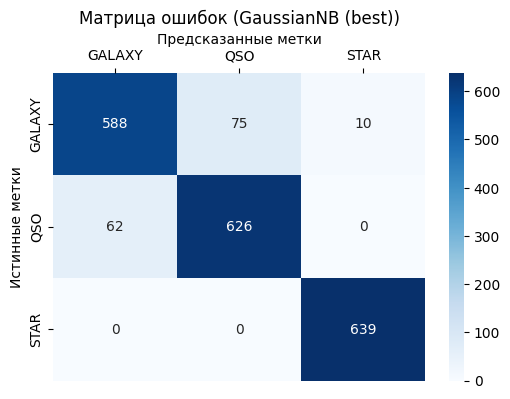

In [182]:
best_gnb = grid_search.best_estimator_

y_train_pred = best_gnb.predict(X_train)
y_test_pred = best_gnb.predict(X_test)
y_train_proba = best_gnb.predict_proba(X_train)
y_test_proba = best_gnb.predict_proba(X_test)

print("\nНаивный Байесовский классификатор (GaussianNB, best)")
calculate_metrics(y_train, y_train_pred, y_train_proba, "обучающего множества")

results.append({
    'Model': 'GaussianNB (best)',
    'Dataset': 'Test',
    **calculate_metrics(y_test, y_test_pred, y_test_proba, "тестового множества")
})

print("\nClassification Report (test, best params):")
print(classification_report(y_test, y_test_pred, digits=4))


y_test_generic = y_test  
y_pred_generic = y_test_pred 
model_name = "GaussianNB (best)" 
label_encoder = le
cm = confusion_matrix(y_test_generic, y_pred_generic)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xticks(rotation=0)  
plt.gca().xaxis.tick_top() 
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title(f'Матрица ошибок ({model_name})')
plt.show()

Модель достигла точности (Accuracy) около 92% на обеих выборках, а также демонстрировала высокие значения метрик Precision, Recall и F1-score (все выше 0.92), что свидетельствует о её эффективности в решении задачи классификации. После настройки гиперпараметра var_smoothing с помощью GridSearchCV была отмечена небольшая, но положительная динамика: метрики точности, полноты и F1-score на тестовом множестве увеличились примерно на 0.2%. Низкая разница между показателями на обучающем и тестовом множествах указывает на низкую склонность к переобучению. Таким образом, подбор гиперпараметра var_smoothing позволил незначительно, но улучшить обобщающую способность модели.

8. Наивный Байесовский классификатор (BernoulliNB) - гиперпараметры по умолчанию <br>

BernoulliNB — это разновидность Наивного Байесовского классификатора, предназначенная для бинарных (двоичных) признаков, то есть признаков, которые могут принимать только два значения (например, 0 или 1, присутствует/отсутствует). Он основывается на распределении Бернулли. Как и другие наивные байесовские классификаторы, BernoulliNB предполагает независимость признаков.<br> 

MultinomialNB и ComplementNB не подходят, так как требуют неотрицательные значения.

Для данного метода проводится предобработка данных с помощью Binarizer. Он преобразует числовые признаки в бинарные (двоичные) значения на основе заданного порога (threshold): все значения признака, строго больше порога, становятся 1.0, а все значения признака, меньше или равны порогу, становятся 0.0.

Наивный Байесовский классификатор (BernoulliNB, default)
=== Метрики для обучающего множества ===
Accuracy: 0.6466
Precision (macro): 0.6483
Precision (micro): 0.6466
Recall (macro): 0.6471
Recall (micro): 0.6466
F1-score (macro): 0.6476
F1-score (micro): 0.6466
AUC (macro, ovr): 0.8061
------------------------------
=== Метрики для тестового множества ===
Accuracy: 0.6530
Precision (macro): 0.6517
Precision (micro): 0.6530
Recall (macro): 0.6514
Recall (micro): 0.6530
F1-score (macro): 0.6506
F1-score (micro): 0.6530
AUC (macro, ovr): 0.8161
------------------------------

Classification Report (test, default):
              precision    recall  f1-score   support

           0     0.5307    0.4874    0.5081       673
           1     0.8535    0.8299    0.8416       688
           2     0.5708    0.6369    0.6021       639

    accuracy                         0.6530      2000
   macro avg     0.6517    0.6514    0.6506      2000
weighted avg     0.6546    0.6530    0.6528      2000


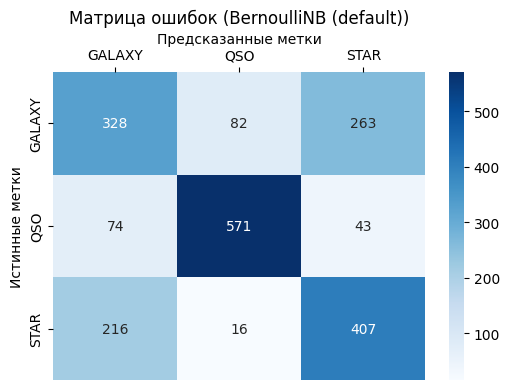

In [183]:
pipe_default = Pipeline([
    ('binarizer', Binarizer(threshold=0.0)), 
    ('bnb', BernoulliNB())  
])

pipe_default.fit(X_train, y_train)

y_train_pred_default = pipe_default.predict(X_train)
y_test_pred_default = pipe_default.predict(X_test)
y_train_proba_default = pipe_default.predict_proba(X_train)
y_test_proba_default = pipe_default.predict_proba(X_test)

print("Наивный Байесовский классификатор (BernoulliNB, default)")
calculate_metrics(y_train, y_train_pred_default, y_train_proba_default, "обучающего множества")

results.append({
    'Model': 'BernoulliNB (default)',
    'Dataset': 'Test',
    **calculate_metrics(y_test, y_test_pred_default, y_test_proba_default, "тестового множества")
})

print("\nClassification Report (test, default):")
print(classification_report(y_test, y_test_pred_default, digits=4))

y_test_generic = y_test  
y_pred_generic = y_test_pred_default 
model_name = "BernoulliNB (default)" 
label_encoder = le
cm = confusion_matrix(y_test_generic, y_pred_generic)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xticks(rotation=0)  
plt.gca().xaxis.tick_top() 
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title(f'Матрица ошибок ({model_name})')
plt.show()

9. Наивный Байесовский классификатор (BernoulliNB) - подбор гиперпараметров<br>

binarizer__threshold (в Binarizer) - порог, по которому числовые значения признаков преобразуются в бинарные (0 или 1). Если значение признака больше порога, оно становится 1, иначе — 0. Выбор порога влияет на то, какие исходные значения считаются "активными" для BernoulliNB. <br>
bnb__alpha (в BernoulliNB) - параметр сглаживания, он помогает избежать нулевых вероятностей для признаков, которые не встречались в обучающих данных для какого-то класса. Чем больше alpha, тем сильнее сглаживание, и "уверенность" модели в оценках вероятностей снижается. <br> 

In [184]:
param_grid_nb = [
    {
        'binarizer__threshold': [-1.0, -0.5, 0.0, 0.5, 1.0],
        'bnb__alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]
    }
]

pipe_nb = Pipeline([
    ('binarizer', Binarizer()),  
    ('bnb', BernoulliNB())       
])

grid_nb = GridSearchCV(
    pipe_nb,
    param_grid_nb,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_nb.fit(X_train, y_train)

print("Лучшие параметры для BernoulliNB:", grid_nb.best_params_)

Лучшие параметры для BernoulliNB: {'binarizer__threshold': 0.5, 'bnb__alpha': 2.0}


10. Наивный Байесовский классификатор (BernoulliNB) - подобранные гиперпараметры

Наивный Байесовский классификатор (BernoulliNB, best)
=== Метрики для обучающего множества ===
Accuracy: 0.6732
Precision (macro): 0.6792
Precision (micro): 0.6732
Recall (macro): 0.6737
Recall (micro): 0.6732
F1-score (macro): 0.6718
F1-score (micro): 0.6732
AUC (macro, ovr): 0.8424
------------------------------
=== Метрики для тестового множества ===
Accuracy: 0.6690
Precision (macro): 0.6776
Precision (micro): 0.6690
Recall (macro): 0.6676
Recall (micro): 0.6690
F1-score (macro): 0.6651
F1-score (micro): 0.6690
AUC (macro, ovr): 0.8464
------------------------------

Classification Report (test, best params):
              precision    recall  f1-score   support

           0     0.7020    0.5111    0.5916       673
           1     0.8017    0.8343    0.8177       688
           2     0.5290    0.6573    0.5862       639

    accuracy                         0.6690      2000
   macro avg     0.6776    0.6676    0.6651      2000
weighted avg     0.6810    0.6690    0.6676      2000

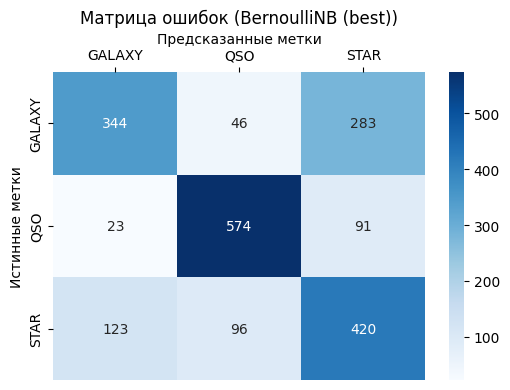

In [185]:
pipe_best = Pipeline([
    ('binarizer', Binarizer(threshold=0.5)), 
    ('bnb', BernoulliNB(alpha=2.0))          
])

pipe_best.fit(X_train, y_train)

y_train_pred_best = pipe_best.predict(X_train)
y_test_pred_best = pipe_best.predict(X_test)
y_train_proba_best = pipe_best.predict_proba(X_train)
y_test_proba_best = pipe_best.predict_proba(X_test)

print("Наивный Байесовский классификатор (BernoulliNB, best)")
calculate_metrics(y_train, y_train_pred_best, y_train_proba_best, "обучающего множества")

results.append({
    'Model': 'BernoulliNB (best)',
    'Dataset': 'Test',
    **calculate_metrics(y_test, y_test_pred_best, y_test_proba_best, "тестового множества")
})

print("\nClassification Report (test, best params):")
print(classification_report(y_test, y_test_pred_best, digits=4))


y_test_generic = y_test  
y_pred_generic = y_test_pred_best 
model_name = "BernoulliNB (best)" 
label_encoder = le
cm = confusion_matrix(y_test_generic, y_pred_generic)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xticks(rotation=0)  
plt.gca().xaxis.tick_top() 
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title(f'Матрица ошибок ({model_name})')
plt.show()

Модель BernoulliNB с параметрами по умолчанию показала умеренные результаты, достигнув точности (Accuracy) около 65% на обеих выборках, а также продемонстрировав сопоставимые значения метрик Precision, Recall и F1-score (все около 0.65). Значение AUC (около 0.81 - 0.82) указывает на удовлетворительную, но не высокую способность модели различать классы. После настройки гиперпараметров threshold в Binarizer и alpha в BernoulliNB с помощью GridSearchCV наблюдалось заметное улучшение: метрики точности, полноты и F1-score на тестовом множестве увеличились примерно на 1.5 - 2.5%, а значение AUC выросло до примерно 0.846. Низкая разница между показателями на обучающем и тестовом множествах как для модели по умолчанию, так и для настроенной, указывает на низкую склонность к переобучению. Таким образом, подбор гиперпараметров threshold и alpha позволил значительно улучшить обобщающую способность модели BernoulliNB.

11. Дерево решений - гиперпараметры по умолчанию <br>

Дерево решений — это модель машинного обучения, которая представляет собой иерархическую структуру, где каждый внутренний узел соответствует проверке значения признака, каждая ветвь — результату этой проверки, а каждый листовой узел — итоговому решению (предсказанию). Алгоритм строит дерево, рекурсивно разбивая обучающую выборку на подмножества, стараясь на каждом шаге выбрать разбиение, которое максимально уменьшает неоднородность (энтропию или дисперсию) в получаемых подмножествах. 

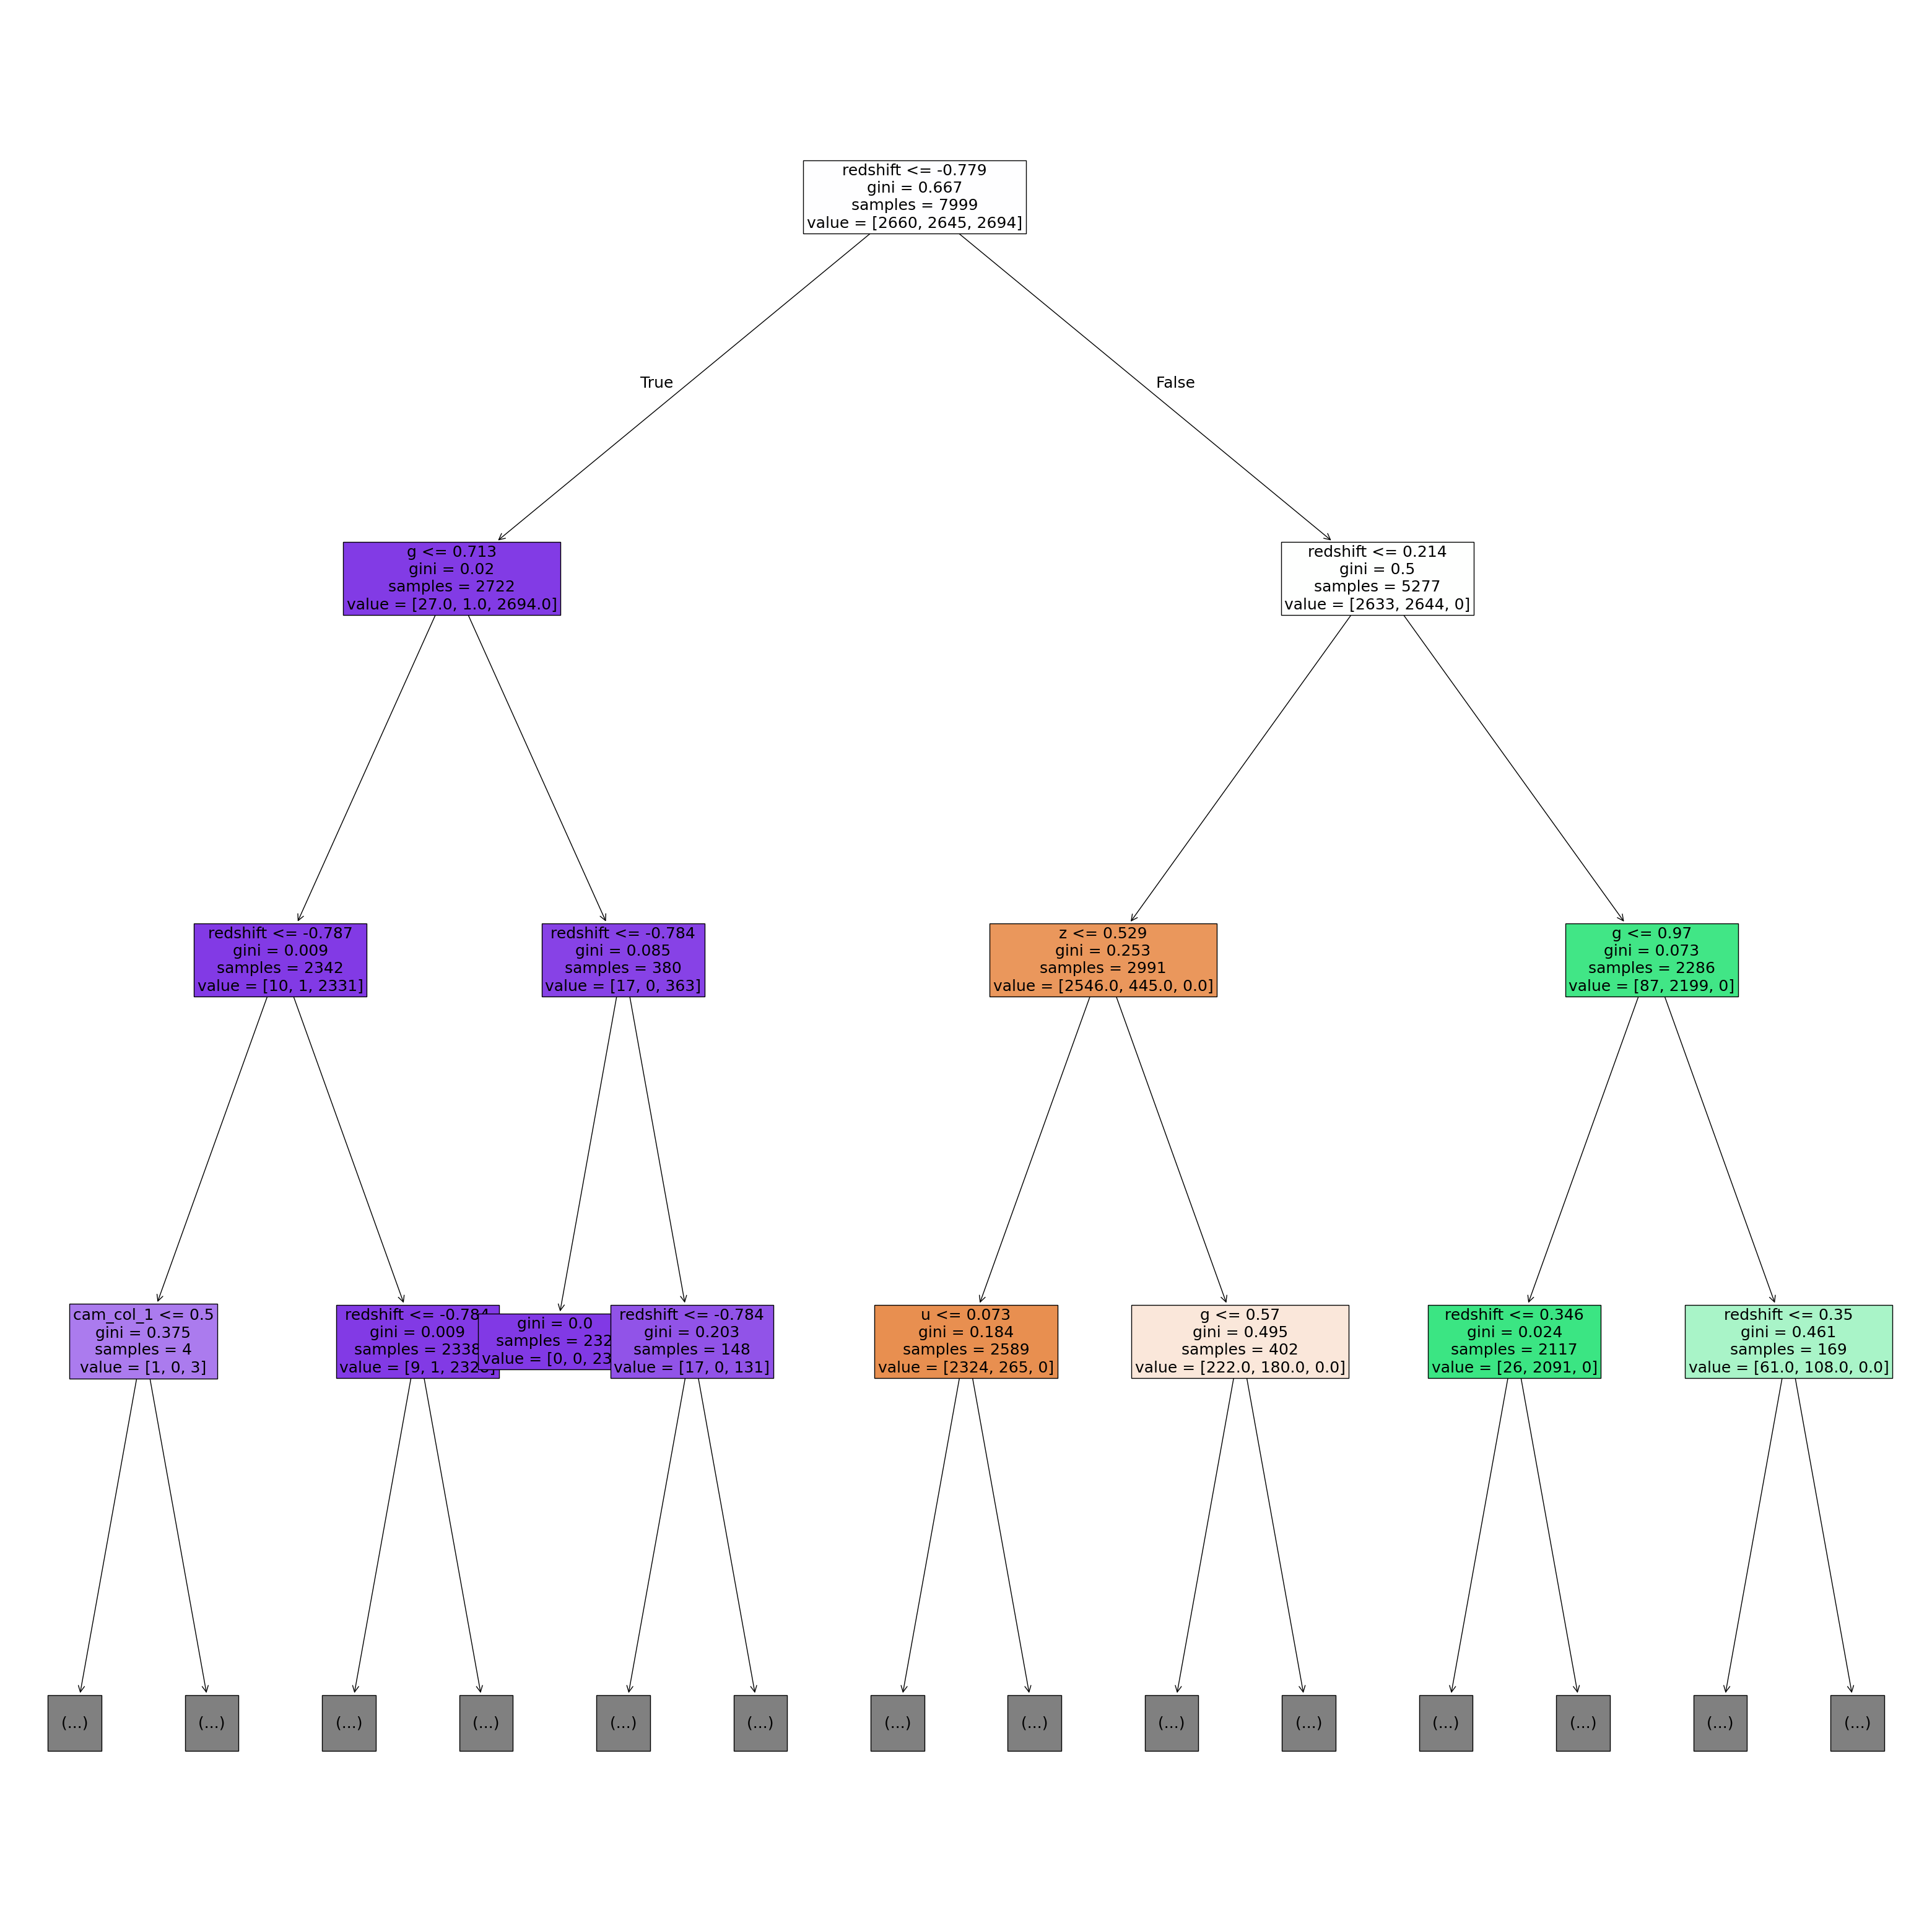

Дерево решений (default)
=== Метрики для обучающего множества ===
Accuracy: 1.0000
Precision (macro): 1.0000
Precision (micro): 1.0000
Recall (macro): 1.0000
Recall (micro): 1.0000
F1-score (macro): 1.0000
F1-score (micro): 1.0000
AUC (macro, ovr): 1.0000
------------------------------
=== Метрики для тестового множества ===
Accuracy: 0.9545
Precision (macro): 0.9554
Precision (micro): 0.9545
Recall (macro): 0.9553
Recall (micro): 0.9545
F1-score (macro): 0.9553
F1-score (micro): 0.9545
AUC (macro, ovr): 0.9661
------------------------------

Classification Report (test, default):
              precision    recall  f1-score   support

           0     0.9398    0.9272    0.9334       673
           1     0.9311    0.9433    0.9372       688
           2     0.9953    0.9953    0.9953       639

    accuracy                         0.9545      2000
   macro avg     0.9554    0.9553    0.9553      2000
weighted avg     0.9545    0.9545    0.9545      2000



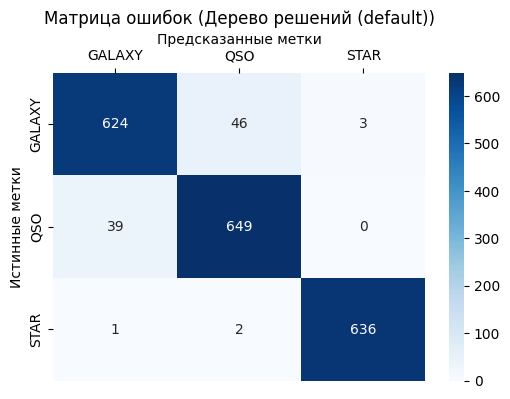

In [186]:
feature_names = (
    numeric_features +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
)

dt_default = DecisionTreeClassifier(random_state=42)
dt_default.fit(X_train, y_train)

y_train_pred_dt_default = dt_default.predict(X_train)
y_test_pred_dt_default = dt_default.predict(X_test)
y_train_proba_dt_default = dt_default.predict_proba(X_train)
y_test_proba_dt_default = dt_default.predict_proba(X_test)

plt.figure(figsize=(40, 40))
plot_tree(dt_default,
          filled=True,
          max_depth=3,
          fontsize=18,
          feature_names=feature_names,
          )
plt.show()

print("Дерево решений (default)")
calculate_metrics(y_train, y_train_pred_dt_default, y_train_proba_dt_default, "обучающего множества")

results.append({
    'Model': 'Дерево решений (default)',
    'Dataset': 'Test',
    **calculate_metrics(y_test, y_test_pred_dt_default, y_test_proba_dt_default, "тестового множества")
})
print("\nClassification Report (test, default):")
print(classification_report(y_test, y_test_pred_dt_default, digits=4))

y_test_generic = y_test  
y_pred_generic = y_test_pred_dt_default 
model_name = "Дерево решений (default)" 
label_encoder = le
cm = confusion_matrix(y_test_generic, y_pred_generic)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xticks(rotation=0)  
plt.gca().xaxis.tick_top() 
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title(f'Матрица ошибок ({model_name})')
plt.show()

12. Дерево решений - подбор гиперпараметров <br>

max_depth - максимально допустимая глубина дерева. Ограничивает, насколько глубоко может разветвляться дерево. None означает, что глубина не ограничена (дерево будет строиться до тех пор, пока все листья не станут "чистыми" или пока не будут выполнены другие критерии остановки). Помогает контролировать переобучение.<br>
min_samples_split - минимальное количество образцов (данных), необходимое для разделения внутреннего узла (не листа). Если в узле меньше образцов, чем задано этим параметром, узел не будет разделяться дальше. Также помогает бороться с переобучением. <br>
min_samples_leaf - минимальное количество образцов, которое должно быть в листовом узле (после разделения). Если разделение приведёт к созданию листа с меньшим количеством образцов, чем задано этим параметром, такое разделение не будет выполнено. Помогает сделать модель более обобщающей. <br>
criterion - функция, используемая для измерения качества разделения. 'gini' — это индекс Джини, 'entropy' — это энтропия. Оба параметра измеряют "неоднородность" классов в узле. Алгоритм стремится выбрать такое разделение, которое максимально уменьшает неоднородность. <br>

Индекс Джини измеряет степень неоднородности узла. Он рассчитывает вероятность того, что случайно выбранная метка будет неправильно классифицирована, если бы она была помечена в соответствии с распределением меток в узле. <br>
Формула: <br>
![alt text](image-7.png),<br>
где C — количество уникальных классов в узле, pi — вероятность наличия класса i в узле.

Энтропия в контексте деревьев решений — это мера неопределенности или неоднородности (хаоса) в наборе данных. Чем однороднее (чистее) группа данных (например, все объекты одного класса), тем ниже энтропия (близка к 0). Чем неоднороднее группа (например, равное количество объектов разных классов), тем выше энтропия (максимальна).
Формула: <br>
![alt text](image-8.png), <br>
где C — количество уникальных классов в узле, pi — доля (вероятность) объектов класса i в этом узле (количество объектов класса i , делённое на общее количество объектов в узле).

In [187]:
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=42)

grid_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_dt.fit(X_train, y_train)

print("Лучшие параметры для дерева:", grid_dt.best_params_)

Лучшие параметры для дерева: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 2}


13. Дерево решений - подобранные гиперпараметры

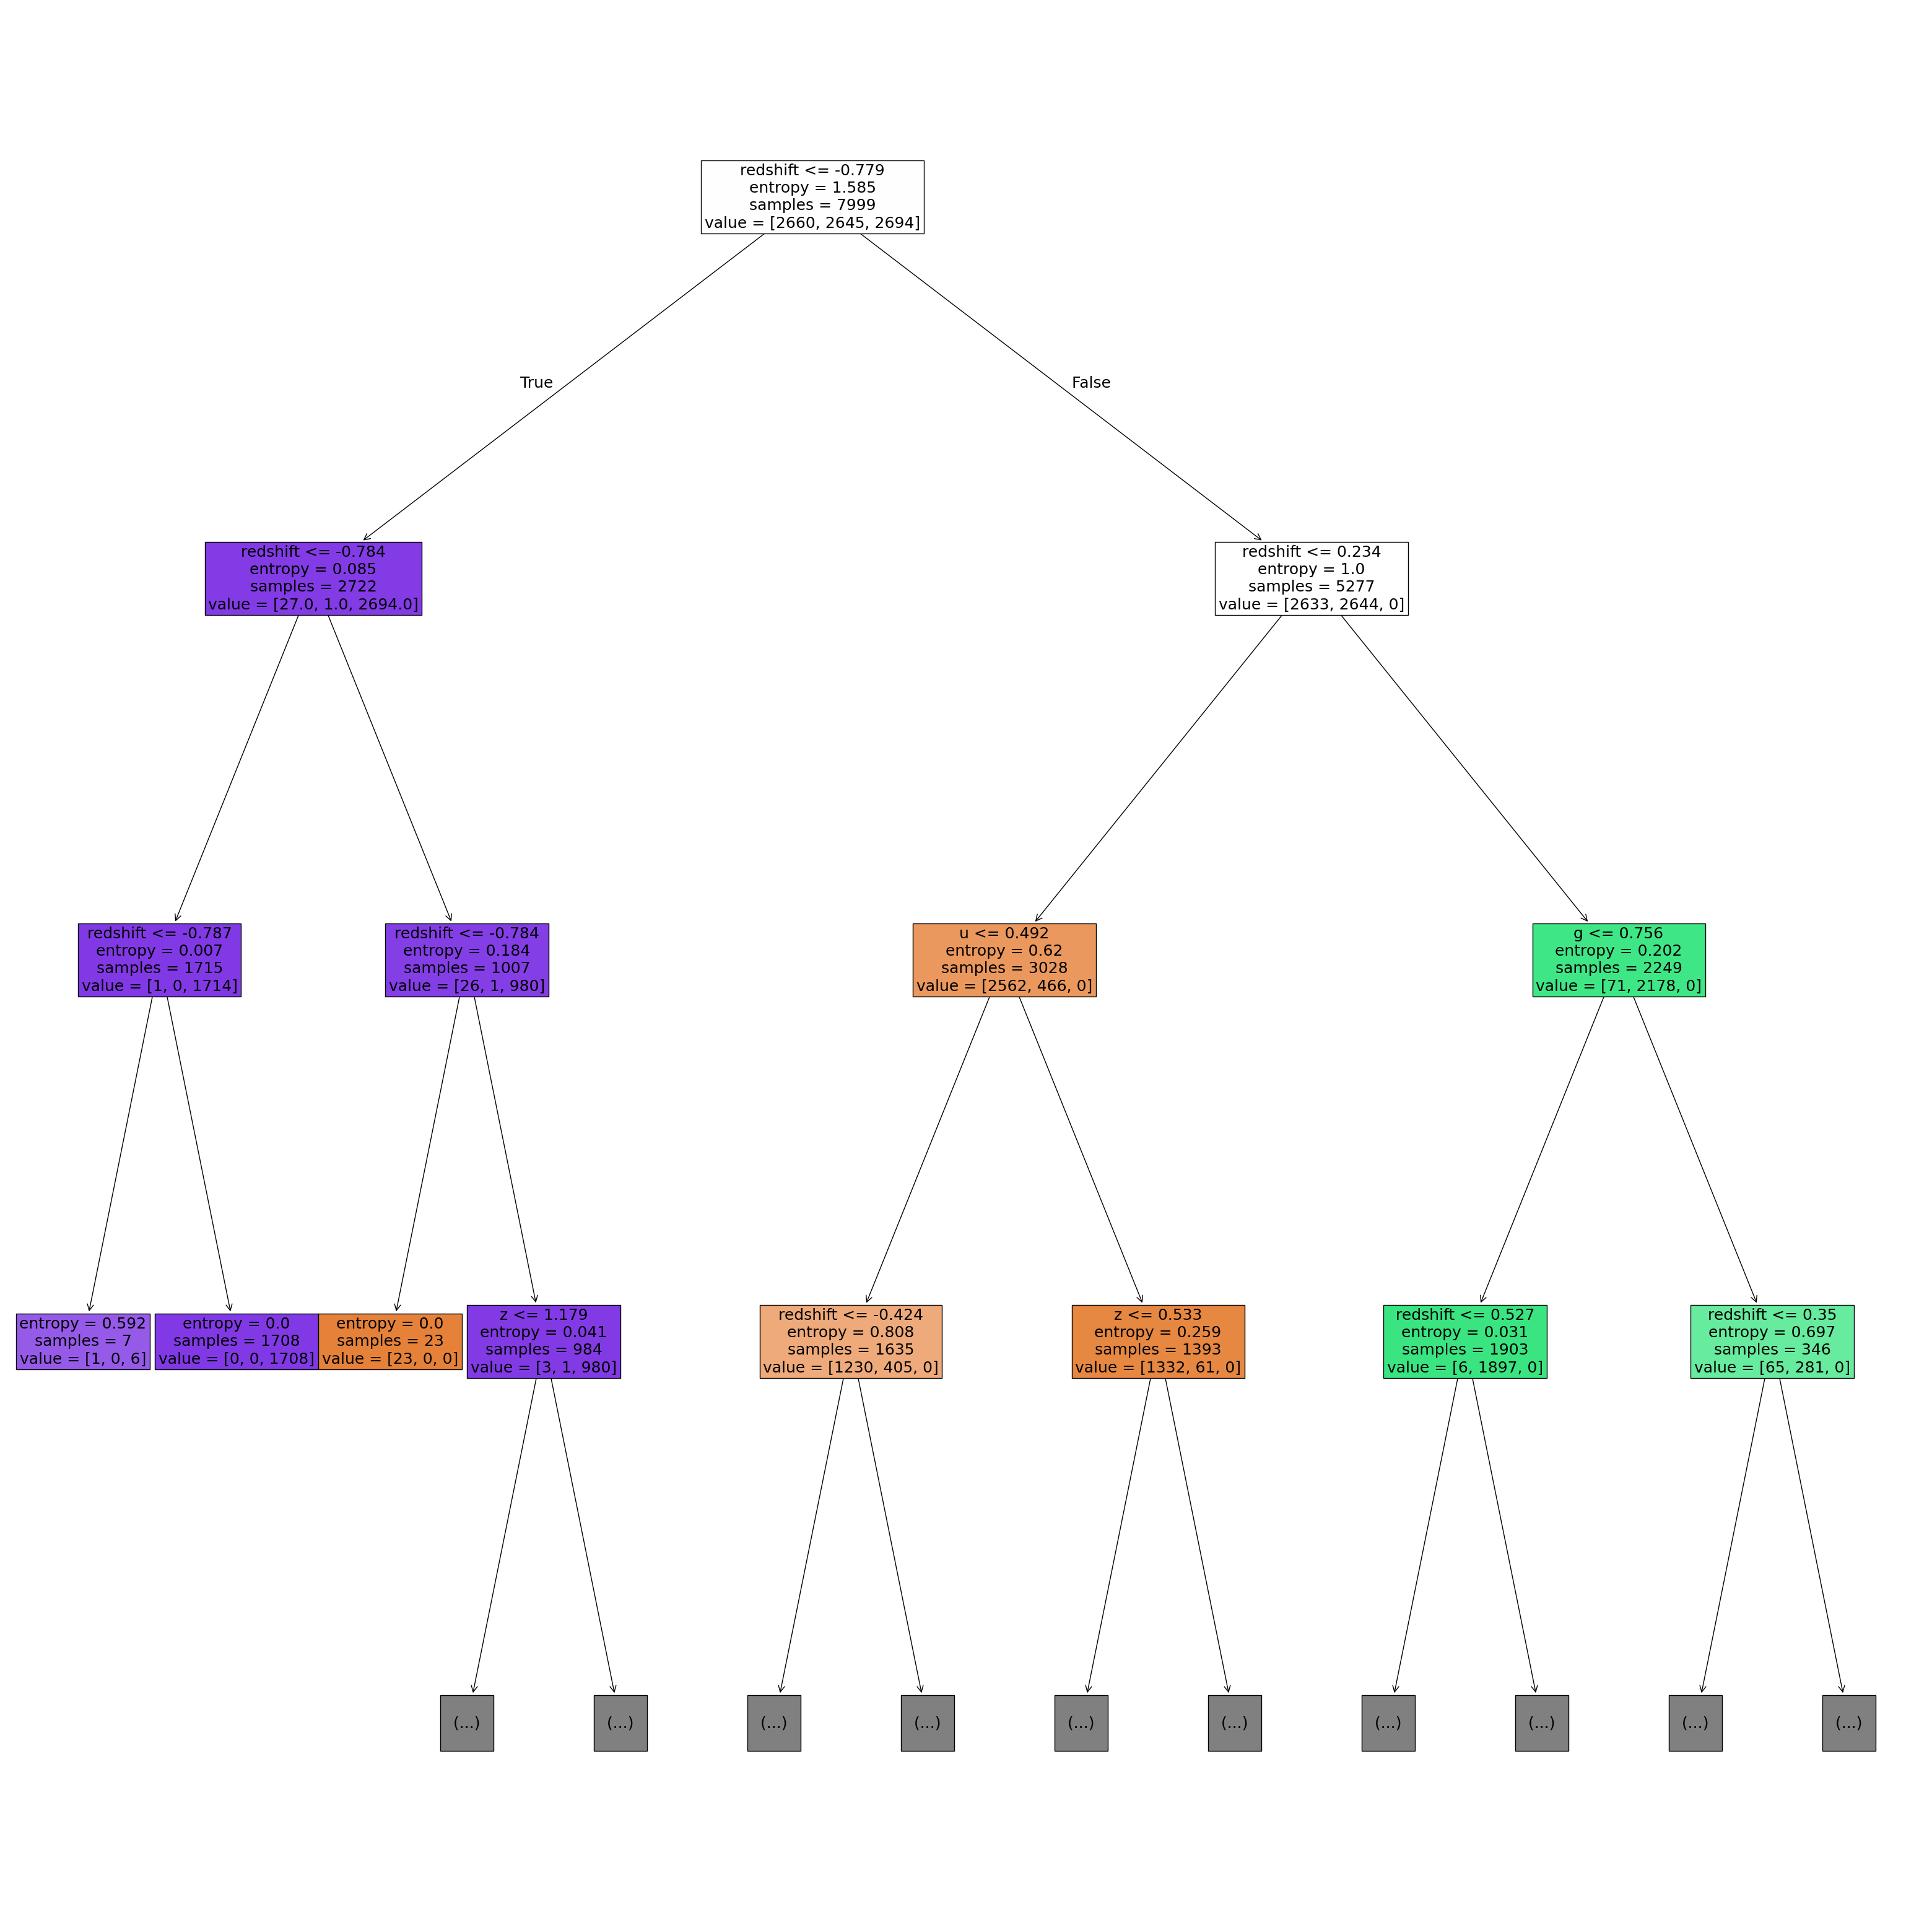

Дерево решений (best) 
=== Метрики для обучающего множества ===
Accuracy: 0.9740
Precision (macro): 0.9741
Precision (micro): 0.9740
Recall (macro): 0.9738
Recall (micro): 0.9740
F1-score (macro): 0.9739
F1-score (micro): 0.9740
AUC (macro, ovr): 0.9971
------------------------------
=== Метрики для тестового множества ===
Accuracy: 0.9635
Precision (macro): 0.9642
Precision (micro): 0.9635
Recall (macro): 0.9643
Recall (micro): 0.9635
F1-score (macro): 0.9642
F1-score (micro): 0.9635
AUC (macro, ovr): 0.9890
------------------------------

Classification Report (test, best params):
              precision    recall  f1-score   support

           0     0.9373    0.9554    0.9463       673
           1     0.9598    0.9375    0.9485       688
           2     0.9953    1.0000    0.9977       639

    accuracy                         0.9635      2000
   macro avg     0.9642    0.9643    0.9642      2000
weighted avg     0.9636    0.9635    0.9635      2000



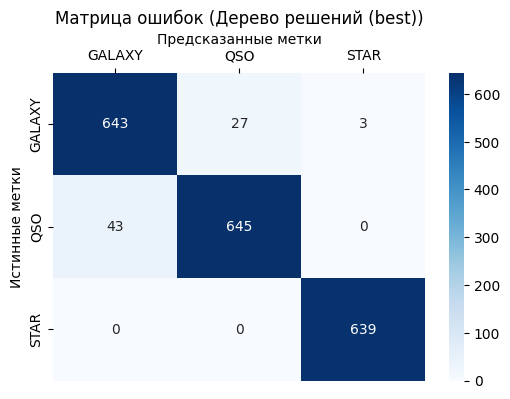

In [188]:
y_train_pred_dt_best = grid_dt.predict(X_train)
y_test_pred_dt_best = grid_dt.predict(X_test)
y_train_proba_dt_best = grid_dt.predict_proba(X_train)
y_test_proba_dt_best = grid_dt.predict_proba(X_test)

best_dt = grid_dt.best_estimator_

plt.figure(figsize=(40, 40))
plot_tree(best_dt,
          filled=True,
          max_depth=3,
          fontsize=18,
          feature_names=feature_names,
          )
plt.show()

print("Дерево решений (best) ")
calculate_metrics(y_train, y_train_pred_dt_best, y_train_proba_dt_best, "обучающего множества")

results.append({
    'Model': 'Дерево решений (best)',
    'Dataset': 'Test',
    **calculate_metrics(y_test, y_test_pred_dt_best, y_test_proba_dt_best, "тестового множества")
})

print("\nClassification Report (test, best params):")
print(classification_report(y_test, y_test_pred_dt_best, digits=4))

y_test_generic = y_test  
y_pred_generic = y_test_pred_dt_best 
model_name = "Дерево решений (best)" 
label_encoder = le
cm = confusion_matrix(y_test_generic, y_pred_generic)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xticks(rotation=0)  
plt.gca().xaxis.tick_top() 
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title(f'Матрица ошибок ({model_name})')
plt.show()

Модель Дерево решений с параметрами по умолчанию показала идеальные метрики (все значения равны 1.0) на обучающем множестве, что является ярким признаком переобучения: модель "запомнила" обучающие данные. Однако на тестовом множестве метрики были значительно ниже, но всё ещё высокими (около 95% для Accuracy, Precision, Recall и F1-score), а значение AUC составило 0.9661. После настройки гиперпараметров (max_depth, min_samples_split, min_samples_leaf, criterion) с помощью GridSearchCV наблюдалось улучшение. На тестовом множестве Accuracy, Precision, Recall и F1-score увеличились примерно до 96.4%, а AUC выросла до 0.9890. На обучающем множестве метрики немного снизились по сравнению с моделью по умолчанию, но остались очень высокими (около 97.4%). Это снижение на обучающей выборке при одновременном росте на тестовой свидетельствует о том, что подбор гиперпараметров успешно снизил переобучение и улучшил обобщающую способность модели.

14. Линейный дискриминантный анализ - гиперпараметры по умолчанию

Линейный дискриминантный анализ (LDA) предполагает, что признаки для каждого класса распределены нормально (гауссово), и что все классы имеют одинаковую ковариационную матрицу. LDA находит линейные комбинации признаков, которые наилучшим образом разделяют классы, проецируя данные на оси, максимизирующие разницу между средними значениями классов и минимизирующие разброс внутри классов. Полученные "дискриминантные функции" затем используются для классификации новых объектов.

LDA (default)
=== Метрики для обучающего множества ===
Accuracy: 0.7903
Precision (macro): 0.7972
Precision (micro): 0.7903
Recall (macro): 0.7905
Recall (micro): 0.7903
F1-score (macro): 0.7926
F1-score (micro): 0.7903
AUC (macro, ovr): 0.9327
------------------------------
=== Метрики для тестового множества ===
Accuracy: 0.7845
Precision (macro): 0.7925
Precision (micro): 0.7845
Recall (macro): 0.7840
Recall (micro): 0.7845
F1-score (macro): 0.7856
F1-score (micro): 0.7845
AUC (macro, ovr): 0.9300
------------------------------

Classification Report (test, default):
              precision    recall  f1-score   support

           0     0.7369    0.6909    0.7132       673
           1     0.9645    0.8677    0.9135       688
           2     0.6760    0.7934    0.7300       639

    accuracy                         0.7845      2000
   macro avg     0.7925    0.7840    0.7856      2000
weighted avg     0.7957    0.7845    0.7875      2000



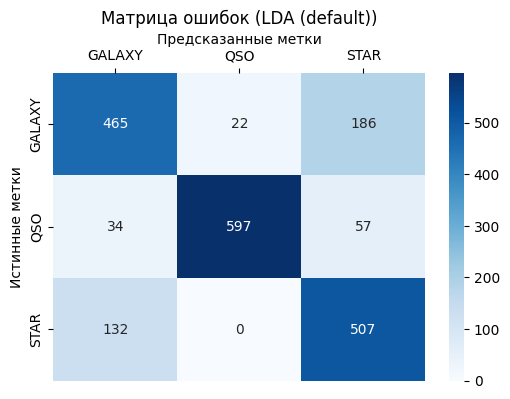

In [189]:
lda_default = LinearDiscriminantAnalysis()
lda_default.fit(X_train, y_train)

y_train_pred_lda_default = lda_default.predict(X_train)
y_test_pred_lda_default = lda_default.predict(X_test)
y_train_proba_lda_default = lda_default.predict_proba(X_train)
y_test_proba_lda_default = lda_default.predict_proba(X_test)

print("LDA (default)")
calculate_metrics(y_train, y_train_pred_lda_default, y_train_proba_lda_default, "обучающего множества")

results.append({
    'Model': 'LDA (default)',
    'Dataset': 'Test',
    **calculate_metrics(y_test, y_test_pred_lda_default, y_test_proba_lda_default, "тестового множества")
})


print("\nClassification Report (test, default):")
print(classification_report(y_test, y_test_pred_lda_default, digits=4))

y_test_generic = y_test  
y_pred_generic = y_test_pred_lda_default 
model_name = "LDA (default)" 
label_encoder = le
cm = confusion_matrix(y_test_generic, y_pred_generic)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xticks(rotation=0)  
plt.gca().xaxis.tick_top() 
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title(f'Матрица ошибок ({model_name})')
plt.show()

15. Линейный дискриминантный анализ - подбор гиперпараметров

solver - алгоритм, используемый для вычисления параметров модели LDA.
- svd: использует сингулярное разложение (Singular Value Decomposition). Этот метод не вычисляет ковариационную матрицу напрямую и может быть более численно устойчивым, особенно при большом количестве признаков или наличии мультиколлинеарности. Является методом по умолчанию.
- lsqr: использует метод наименьших квадратов. Может быть быстрее для больших наборов данных, но требует вычисления ковариационной матрицы.

In [190]:
param_grid_lda = [
    {'solver': ['svd']},  
    {'solver': ['lsqr'], 'shrinkage': [None]}  
]

lda = LinearDiscriminantAnalysis()

grid_lda = GridSearchCV(lda, param_grid_lda, cv=5, scoring='accuracy', n_jobs=-1)
grid_lda.fit(X_train, y_train)

print("Лучшие параметры для LDA:", grid_lda.best_params_)

Лучшие параметры для LDA: {'solver': 'svd'}


16. Линейный дискриминантный анализ - подобранные гиперпараметры

LDA (best)
=== Метрики для обучающего множества ===
Accuracy: 0.7903
Precision (macro): 0.7972
Precision (micro): 0.7903
Recall (macro): 0.7905
Recall (micro): 0.7903
F1-score (macro): 0.7926
F1-score (micro): 0.7903
AUC (macro, ovr): 0.9327
------------------------------
=== Метрики для тестового множества ===
Accuracy: 0.7845
Precision (macro): 0.7925
Precision (micro): 0.7845
Recall (macro): 0.7840
Recall (micro): 0.7845
F1-score (macro): 0.7856
F1-score (micro): 0.7845
AUC (macro, ovr): 0.9300
------------------------------

Classification Report (test, best params):
              precision    recall  f1-score   support

           0     0.7369    0.6909    0.7132       673
           1     0.9645    0.8677    0.9135       688
           2     0.6760    0.7934    0.7300       639

    accuracy                         0.7845      2000
   macro avg     0.7925    0.7840    0.7856      2000
weighted avg     0.7957    0.7845    0.7875      2000



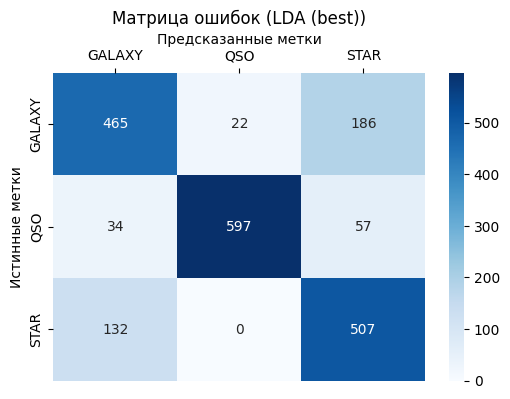

In [191]:
y_train_pred_lda_best = grid_lda.predict(X_train)
y_test_pred_lda_best = grid_lda.predict(X_test)
y_train_proba_lda_best = grid_lda.predict_proba(X_train)
y_test_proba_lda_best = grid_lda.predict_proba(X_test)

print("LDA (best)")
calculate_metrics(y_train, y_train_pred_lda_best, y_train_proba_lda_best, "обучающего множества")

results.append({
    'Model': 'LDA (best)',
    'Dataset': 'Test',
    **calculate_metrics(y_test, y_test_pred_lda_best, y_test_proba_lda_best, "тестового множества")
})

print("\nClassification Report (test, best params):")
print(classification_report(y_test, y_test_pred_lda_best, digits=4))

y_test_generic = y_test  
y_pred_generic = y_test_pred_lda_best 
model_name = "LDA (best)" 
label_encoder = le
cm = confusion_matrix(y_test_generic, y_pred_generic)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xticks(rotation=0)  
plt.gca().xaxis.tick_top() 
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title(f'Матрица ошибок ({model_name})')
plt.show()

Модель с параметрами по умолчанию показала стабильные результаты, с небольшой разницей между метриками на обучающем и тестовом множествах (например, Accuracy 0.7903 и 0.7845). Это говорит о низкой склонности к переобучению. Значения метрик Precision, Recall и F1-score также были сопоставимы (около 0.78 - 0.79), а значение AUC составило примерно 0.93, что указывает на удовлетворительную, но не рекордно высокую способность модели различать классы. После настройки гиперпараметра solver не наблюдалось никаких изменений в результатах: метрики для "лучшей" модели оказались идентичны метрикам модели по умолчанию. Это может означать, что параметры по умолчанию уже оптимальны для данной задачи и набора данных. 

17. Метод опорных векторов - гиперпараметры по умолчанию <br>

Основная идея метода опорных векторов заключается в поиске гиперплоскости, которая наилучшим образом разделяет объекты разных классов в пространстве признаков. Эта гиперплоскость выбирается так, чтобы максимизировать отступ — расстояние до ближайших точек обучающей выборки (опорных векторов) от каждого класса. 

SVM (default)
=== Метрики для обучающего множества ===
Accuracy: 0.9302
Precision (macro): 0.9319
Precision (micro): 0.9302
Recall (macro): 0.9300
Recall (micro): 0.9302
F1-score (macro): 0.9303
F1-score (micro): 0.9302
AUC (macro, ovr): 0.9890
------------------------------
=== Метрики для тестового множества ===
Accuracy: 0.9240
Precision (macro): 0.9254
Precision (micro): 0.9240
Recall (macro): 0.9250
Recall (micro): 0.9240
F1-score (macro): 0.9239
F1-score (micro): 0.9240
AUC (macro, ovr): 0.9863
------------------------------

Classification Report (test, default):
              precision    recall  f1-score   support

           0     0.9034    0.8752    0.8891       673
           1     0.9860    0.9186    0.9511       688
           2     0.8868    0.9812    0.9316       639

    accuracy                         0.9240      2000
   macro avg     0.9254    0.9250    0.9239      2000
weighted avg     0.9265    0.9240    0.9240      2000



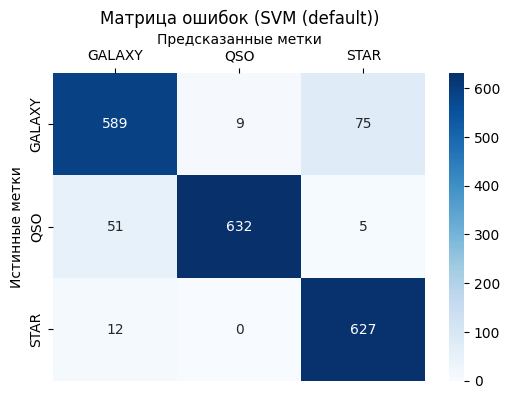

In [192]:
svm_pipe_default = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(random_state=42, probability=True))
])

svm_pipe_default.fit(X_train, y_train)

y_train_pred_svm_default = svm_pipe_default.predict(X_train)
y_test_pred_svm_default = svm_pipe_default.predict(X_test)
y_train_proba_svm_default = svm_pipe_default.predict_proba(X_train)
y_test_proba_svm_default = svm_pipe_default.predict_proba(X_test)

print("SVM (default)")
calculate_metrics(y_train, y_train_pred_svm_default, y_train_proba_svm_default, "обучающего множества")

results.append({
    'Model': 'SVM (default)',
    'Dataset': 'Test',
    **calculate_metrics(y_test, y_test_pred_svm_default, y_test_proba_svm_default, "тестового множества")

})

print("\nClassification Report (test, default):")
print(classification_report(y_test, y_test_pred_svm_default, digits=4))

y_test_generic = y_test  
y_pred_generic = y_test_pred_svm_default 
model_name = "SVM (default)" 
label_encoder = le
cm = confusion_matrix(y_test_generic, y_pred_generic)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xticks(rotation=0)  
plt.gca().xaxis.tick_top() 
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title(f'Матрица ошибок ({model_name})')
plt.show()

18. Метод опорных векторов - подбор гиперпараметров

svm__C - параметр регуляризации. Он контролирует компромисс между минимизацией ошибки классификации на обучающей выборке и максимизацией ширины разделяющей полосы (маржинальности). Меньшие значения C создают более широкую полосу, но могут допускать больше ошибок на обучающих данных (меньше штраф за ошибки). Более высокие значения C строго наказывают за ошибки, стремясь правильно классифицировать все обучающие примеры, что может привести к более узкой полосе и потенциальному переобучению. <br><br>
svm__kernel: функция ядра, используемая для построения разделяющей гиперповерхности.
- linear: линейное ядро. Создаёт линейную разделяющую границу (гиперплоскость). Подходит для линейно разделимых данных или когда признаки уже хорошо представляют линейные отношения.
- rbf: гауссово ядро. Позволяет создавать нелинейные разделяющие границы. Является одним из самых популярных ядер. <br>

svm__gamma (имеет смысл только при kernel=rbf): Определяет радиус влияния одного обучающего примера. Он влияет на форму нелинейной разделяющей границы.
- scale: (Значение по умолчанию) gamma = 1 / (n_features * X.var()).
- auto: gamma = 1 / n_features.
- числовые значения (0.001, 0.01, 0.1 и т.д.): позволяют задать конкретное значение. Меньшие значения gamma означают более "далёкое" влияние, создавая более гладкие границы. Более высокие значения gamma означают более "локальное" влияние, что может привести к более сложным, извилистым границам и потенциальному переобучению.

In [193]:
param_grid_svm = [
    {
        'svm__C': [0.1, 1, 10],
        'svm__kernel': ['linear']
    },
    {
        'svm__C': [0.1, 1, 10],
        'svm__kernel': ['rbf'],
        'svm__gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
    }
]

svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(random_state=42, probability=True)) 
])

grid_svm = GridSearchCV(svm_pipe, param_grid_svm, cv=3, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train, y_train)

print("Лучшие параметры для SVM:", grid_svm.best_params_)

Лучшие параметры для SVM: {'svm__C': 10, 'svm__kernel': 'linear'}


19. Метод опорных векторов - подобранные гиперпараметры

SVM (best)
=== Метрики для обучающего множества ===
Accuracy: 0.9546
Precision (macro): 0.9546
Precision (micro): 0.9546
Recall (macro): 0.9544
Recall (micro): 0.9546
F1-score (macro): 0.9543
F1-score (micro): 0.9546
AUC (macro, ovr): 0.9896
------------------------------
=== Метрики для тестового множества ===
Accuracy: 0.9540
Precision (macro): 0.9546
Precision (micro): 0.9540
Recall (macro): 0.9550
Recall (micro): 0.9540
F1-score (macro): 0.9545
F1-score (micro): 0.9540
AUC (macro, ovr): 0.9892
------------------------------

Classification Report (test, best params):
              precision    recall  f1-score   support

           0     0.9217    0.9450    0.9332       673
           1     0.9709    0.9201    0.9448       688
           2     0.9711    1.0000    0.9854       639

    accuracy                         0.9540      2000
   macro avg     0.9546    0.9550    0.9545      2000
weighted avg     0.9544    0.9540    0.9539      2000



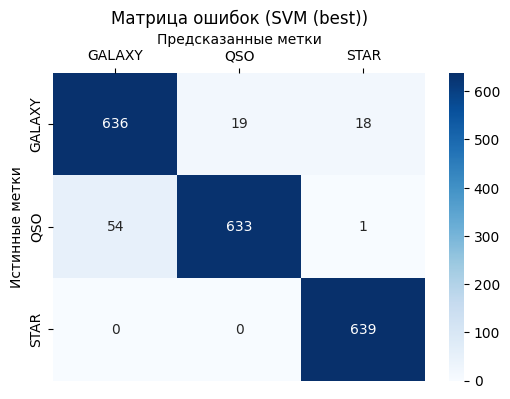

In [194]:
y_train_pred_svm_best = grid_svm.predict(X_train)
y_test_pred_svm_best = grid_svm.predict(X_test)
y_train_proba_svm_best = grid_svm.predict_proba(X_train)
y_test_proba_svm_best = grid_svm.predict_proba(X_test)

print("SVM (best)")
calculate_metrics(y_train, y_train_pred_svm_best, y_train_proba_svm_best, "обучающего множества")

results.append({
    'Model': 'SVM (best)',
    'Dataset': 'Test',
    **calculate_metrics(y_test, y_test_pred_svm_best, y_test_proba_svm_best, "тестового множества")

})

print("\nClassification Report (test, best params):")
print(classification_report(y_test, y_test_pred_svm_best, digits=4))

y_test_generic = y_test  
y_pred_generic = y_test_pred_svm_best 
model_name = "SVM (best)" 
label_encoder = le
cm = confusion_matrix(y_test_generic, y_pred_generic)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xticks(rotation=0)  
plt.gca().xaxis.tick_top() 
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title(f'Матрица ошибок ({model_name})')
plt.show()

Модель метода опорных векторов (SVM) с параметрами по умолчанию показала высокую производительность, достигнув значений Accuracy, Precision, Recall и F1-score около 92 - 93% на тестовом множестве и около 93% на обучающем. Значение AUC (0.9863 на тесте) также свидетельствует о хорошей способности модели различать классы. Небольшая разница между метриками на обучающей и тестовой выборках указывает на умеренную склонность к переобучению. После настройки гиперпараметров на тестовом множестве Accuracy, Precision, Recall и F1-score увеличились до примерно 95.4%, а значение AUC также возросло (до 0.9892). На обучающем множестве метрики также увеличились до примерно 95.5%, при этом разница между обучающим и тестовым показателями осталась небольшой. Это указывает на то, что подбор гиперпараметров не только повысил общую точность модели, но и сохранил её устойчивость к переобучению. Таким образом, настроенная модель SVM демонстрирует существенно лучшую обобщающую способность и общую производительность по сравнению с моделью по умолчанию.

20. Метод ближайших соседей - гиперпараметры по умолчанию <br>

Метод ближайших соседей - метод, который работает по принципу "соседства": для классификации нового объекта алгоритм находит k ближайших ему точек (соседей) в обучающей выборке на основе выбранной метрики расстояния (например, евклидова). Затем, для классификации, объект относится к классу, который является наиболее распространённым среди этих k соседей. 

k-NN (default)
=== Метрики для обучающего множества ===
Accuracy: 0.8994
Precision (macro): 0.9045
Precision (micro): 0.8994
Recall (macro): 0.8995
Recall (micro): 0.8994
F1-score (macro): 0.9005
F1-score (micro): 0.8994
AUC (macro, ovr): 0.9828
------------------------------
=== Метрики для тестового множества ===
Accuracy: 0.8510
Precision (macro): 0.8553
Precision (micro): 0.8510
Recall (macro): 0.8497
Recall (micro): 0.8510
F1-score (macro): 0.8513
F1-score (micro): 0.8510
AUC (macro, ovr): 0.9474
------------------------------

Classification Report (test, default):
              precision    recall  f1-score   support

           0     0.7732    0.8559    0.8124       673
           1     0.9732    0.8968    0.9334       688
           2     0.8196    0.7966    0.8079       639

    accuracy                         0.8510      2000
   macro avg     0.8553    0.8497    0.8513      2000
weighted avg     0.8568    0.8510    0.8526      2000



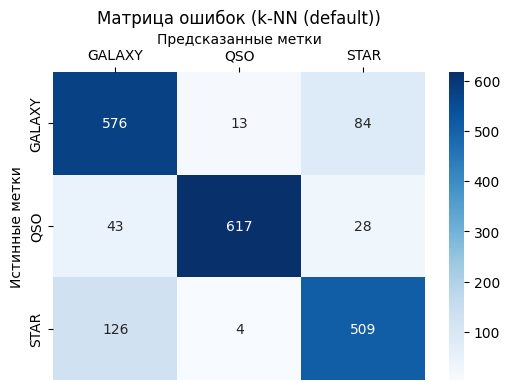

In [195]:
knn_pipe_default = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

knn_pipe_default.fit(X_train, y_train)

y_train_pred_knn_default = knn_pipe_default.predict(X_train)
y_test_pred_knn_default = knn_pipe_default.predict(X_test)
y_train_proba_knn_default = knn_pipe_default.predict_proba(X_train)
y_test_proba_knn_default = knn_pipe_default.predict_proba(X_test)

print("k-NN (default)")
calculate_metrics(y_train, y_train_pred_knn_default, y_train_proba_knn_default, "обучающего множества")

results.append({
    'Model': 'k-NN (default)',
    'Dataset': 'Test',
    **calculate_metrics(y_test, y_test_pred_knn_default, y_test_proba_knn_default, "тестового множества")

})

print("\nClassification Report (test, default):")
print(classification_report(y_test, y_test_pred_knn_default, digits=4))

y_test_generic = y_test  
y_pred_generic = y_test_pred_knn_default 
model_name = "k-NN (default)" 
label_encoder = le
cm = confusion_matrix(y_test_generic, y_pred_generic)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xticks(rotation=0)  
plt.gca().xaxis.tick_top() 
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title(f'Матрица ошибок ({model_name})')
plt.show()

21. Метод ближайших соседей - подбор гиперпараметров

knn__n_neighbors - количество ближайших соседей (k), используемых для классификации. При предсказании для нового объекта алгоритм смотрит на n_neighbors ближайших точек из обучающей выборки и на основе них принимает решение (например, выбирает наиболее частый класс среди соседей). Меньшие значения могут привести к переобучению, большие — к недообучению. <br>
knn__weights - способ взвешивания влияния соседей при голосовании/предсказании
- uniform: все соседи имеют одинаковый вес (влияние)
- distance: вес соседа обратно пропорционален его расстоянию до нового объекта. Более близкие соседи оказывают большее влияние на предсказание.<br>

knn__metric - метрика расстояния, используемая для определения "ближайших" соседей
- euclidean: евклидово расстояние (корень из суммы квадратов разностей координат). 
- manhattan: манхэттенское (или такси) расстояние (сумма абсолютных разностей координат). Хорошо работает, когда данные имеют много признаков, которые могут быть независимы.
- minkowski: обобщение евклидового и манхэттенского расстояний. При p=1 становится манхэттенским, при p=2 — евклидовым. <br>

knn__p - параметр, используемый только при metric='minkowski'. Определяет порядок нормы в формуле расстояния Минковского. 

In [196]:
param_grid_knn = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 15],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
    'knn__p': [1, 2]  
}

knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

grid_knn = GridSearchCV(knn_pipe, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train, y_train)

print("Лучшие параметры для k-NN:", grid_knn.best_params_)

Лучшие параметры для k-NN: {'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'distance'}


22. Метод ближайших соседей - подобранные гиперпараметры

k-NN (best)
=== Метрики для обучающего множества ===
Accuracy: 1.0000
Precision (macro): 1.0000
Precision (micro): 1.0000
Recall (macro): 1.0000
Recall (micro): 1.0000
F1-score (macro): 1.0000
F1-score (micro): 1.0000
AUC (macro, ovr): 1.0000
------------------------------
=== Метрики для тестового множества ===
Accuracy: 0.8800
Precision (macro): 0.8828
Precision (micro): 0.8800
Recall (macro): 0.8796
Recall (micro): 0.8800
F1-score (macro): 0.8804
F1-score (micro): 0.8800
AUC (macro, ovr): 0.9611
------------------------------

Classification Report (test, best params):
              precision    recall  f1-score   support

           0     0.8238    0.8752    0.8487       673
           1     0.9794    0.8997    0.9379       688
           2     0.8453    0.8638    0.8545       639

    accuracy                         0.8800      2000
   macro avg     0.8828    0.8796    0.8804      2000
weighted avg     0.8842    0.8800    0.8812      2000



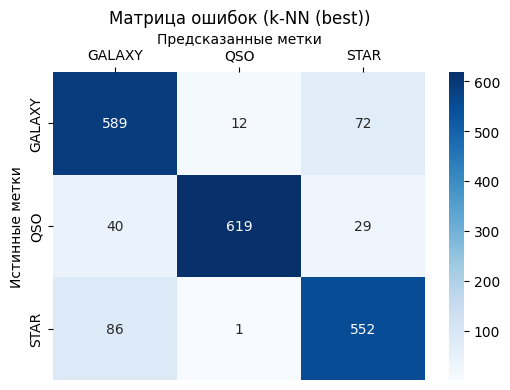

In [197]:
y_train_pred_knn_best = grid_knn.predict(X_train)
y_test_pred_knn_best = grid_knn.predict(X_test)
y_train_proba_knn_best = grid_knn.predict_proba(X_train)
y_test_proba_knn_best = grid_knn.predict_proba(X_test)

print("k-NN (best)")
calculate_metrics(y_train, y_train_pred_knn_best, y_train_proba_knn_best, "обучающего множества")

results.append({
    'Model': 'k-NN (best)',
    'Dataset': 'Test',
    **calculate_metrics(y_test, y_test_pred_knn_best, y_test_proba_knn_best, "тестового множества")

})

print("\nClassification Report (test, best params):")
print(classification_report(y_test, y_test_pred_knn_best, digits=4))

y_test_generic = y_test  
y_pred_generic = y_test_pred_knn_best 
model_name = "k-NN (best)" 
label_encoder = le
cm = confusion_matrix(y_test_generic, y_pred_generic)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xticks(rotation=0)  
plt.gca().xaxis.tick_top() 
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title(f'Матрица ошибок ({model_name})')
plt.show()

Модель с параметрами по умолчанию показала умеренно высокую производительность, достигнув значений Accuracy, Precision, Recall и F1-score около 85% на тестовом множестве и около 90% на обучающем.  Разница между метриками на обучающей и тестовой выборках свидетельствует о небольшом переобучении. После настройки гиперпараметров наблюдалось улучшение: на тестовом множестве Accuracy, Precision, Recall и F1-score увеличились примерно до 88%. Однако, модель, полученная после подбора, показала идеальные метрики (1.0) на обучающем множестве, что указывает на сильное переобучение на обучающую выборку. Несмотря на это, улучшение метрик на тестовом множестве по сравнению с моделью по умолчанию говорит о том, что подбор гиперпараметров позволил найти конфигурацию, которая лучше обобщает на этот конкретный тестовый набор, хотя и ценой увеличения склонности к переобучению на обучающую выборку. 

23. Нейронная сеть

Искусственная нейронная сеть построена по принципу многослойного перцептрона (MLP). Модель состоит из последовательно соединённых слоёв: один входной слой, два скрытых слоя с нелинейной активацией (ReLU) и один выходной слой. <br>

Признаки (входные данные) подаются на первый слой. Скрытые слои (Dense(64, ...) и Dense(32, ...)) обрабатывают эти признаки с помощью нелинейных функций активации. <br>
Каждый нейрон в слое Dense(64, ...) соединён со всеми нейронами предыдущего слоя (в данном случае — с выходами предыдущего слоя признаков после preprocessor).<br>
Каждый нейрон в слое Dense(32, ...) соединён со всеми нейронами предыдущего слоя (Dense(64, ...)).<br>
Наконец, выходной слой Dense(1, ...) также соединён со всеми нейронами предыдущего слоя (Dense(32, ...)). В этом слое будет вектор из n чисел (где n — количество классов, на которые классифицируются данные). Каждое число в этом векторе представляет вероятность того, что входной образец принадлежит соответствующему классу. Эти числа находятся в диапазоне от 0 до 1, и их сумма всегда равна 1 (функции активации softmax). <br>

Dropout используется для регуляризации. Слои Dropout не изменяют архитектуру на "разреженную" — они просто случайным образом "отключают" часть нейронов во время обучения для борьбы с переобучением, но структура полносвязности сохраняется.


При компиляции модели используется алгоритм оптимизации Adam, который эффективно обновляет веса сети, функция потерь categorical_crossentropy, подходящая для многоклассовой классификации с one-hot кодированием, и метрика accuracy для оценки доли правильных предсказаний.

c:\Документы\НГТУ\7 семестр\ИИ и машинное обучение\лабы\lab3\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6229 - loss: 0.7846 - val_accuracy: 0.7575 - val_loss: 0.5627
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7631 - loss: 0.5540 - val_accuracy: 0.8375 - val_loss: 0.4283
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8248 - loss: 0.4384 - val_accuracy: 0.8794 - val_loss: 0.3283
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8520 - loss: 0.3800 - val_accuracy: 0.8975 - val_loss: 0.2921
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8706 - loss: 0.3345 - val_accuracy: 0.9181 - val_loss: 0.2555
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8861 - loss: 0.3096 - val_accuracy: 0.9106 - val_loss: 0.2430
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8997 - loss: 0.2881 - val_accuracy: 0.9300 - val_loss: 0.2233
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9101 - loss: 0.2573 - val_accuracy: 0.

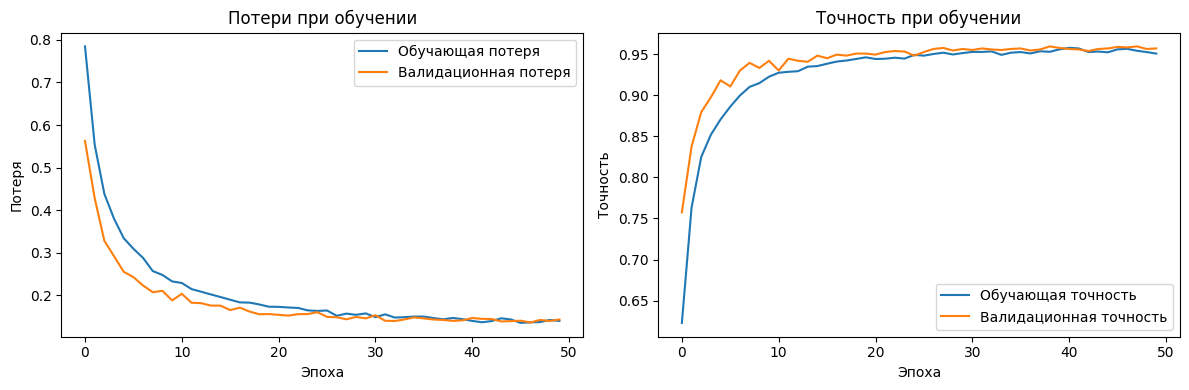

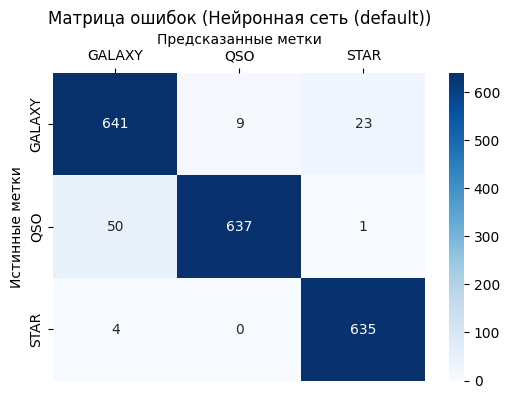

In [198]:
scaler_nn = StandardScaler()
X_train_nn = scaler_nn.fit_transform(X_train)
X_test_nn = scaler_nn.transform(X_test)

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

n_classes = y_train_cat.shape[1]
n_features = X_train_nn.shape[1]

model = Sequential([
    Dense(64, activation='relu', input_shape=(n_features,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax') 
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  
    metrics=['accuracy']
)

history = model.fit(
    X_train_nn, y_train_cat,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

y_train_pred_nn = model.predict(X_train_nn)
y_test_pred_nn = model.predict(X_test_nn)

y_train_pred_classes = np.argmax(y_train_pred_nn, axis=1)
y_test_pred_classes = np.argmax(y_test_pred_nn, axis=1)

y_train_proba_nn = y_train_pred_nn
y_test_proba_nn = y_test_pred_nn

print("Нейронная сеть (default)")
calculate_metrics(y_train, y_train_pred_classes, y_train_proba_nn, "обучающего множества")

results.append({
    'Model': 'Нейронная сеть (default)',
    'Dataset': 'Test',
    **calculate_metrics(y_test, y_test_pred_classes, y_test_proba_nn, "тестового множества")

})

print("\nClassification Report (test, default):")
print(classification_report(y_test, y_test_pred_classes, digits=4))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Обучающая потеря')
plt.plot(history.history['val_loss'], label='Валидационная потеря')
plt.title('Потери при обучении')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Обучающая точность')
plt.plot(history.history['val_accuracy'], label='Валидационная точность')
plt.title('Точность при обучении')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.tight_layout()
plt.show()


y_test_generic = y_test  
y_pred_generic = y_test_pred_classes 
model_name = "Нейронная сеть (default)" 
label_encoder = le
cm = confusion_matrix(y_test_generic, y_pred_generic)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xticks(rotation=0)  
plt.gca().xaxis.tick_top() 
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title(f'Матрица ошибок ({model_name})')
plt.show()

Обучающая и валидационная потери быстро снижаются в начале обучения (примерно до 10 эпох), затем стабилизируются на низком уровне.Кривые близки друг к другу — это признак отсутствия сильного переобучения. Модель хорошо обобщает. <br>

Обучающая и валидационная точности растут, быстро достигая высокого уровня (около 0.95) и стабилизируются. Валидационная точность чуть выше или на одном уровне с обучающей — ещё один признак хорошего обобщения.

24. Нейронная сеть - подбор гиперпараметров и вывод результатов для модели с подобранными гиперпараметрами

num_layers - количество скрытых слоёв в сети (не считая входной и выходной). Ищется значение от 2 до 4 (включительно). <br>
units -  количество нейронов (размерность) в каждом из num_layers скрытых слоёв. Значение для каждого слоя подбирается индивидуально в диапазоне от 32 до 512 с шагом 32.<br>
dropout - вероятность отключения нейрона в слое Dropout, который следует сразу после каждого из num_layers скрытых слоёв. Значение для каждого слоя подбирается индивидуально в диапазоне от 0.0 до 0.5 с шагом 0.1.<br>
learning_rate - скорость обучения для оптимизатора Adam. Подбирается значение в логарифмическом масштабе от 0.0001 (1e-4) до 0.01 (1e-2).

Reloading Tuner from C:/nn_tuning_logs\nn_tuning\tuner0.json


c:\Документы\НГТУ\7 семестр\ИИ и машинное обучение\лабы\lab3\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Документы\НГТУ\7 семестр\ИИ и машинное обучение\лабы\lab3\venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9523 - loss: 0.1379 - val_accuracy: 0.9469 - val_loss: 0.1718
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9537 - loss: 0.1386 - val_accuracy: 0.9513 - val_loss: 0.1622
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9497 - loss: 0.1416 - val_accuracy: 0.9581 - val_loss: 0.1504
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9517 - loss: 0.1334 - val_accuracy: 0.9519 - val_loss: 0.1496
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9537 - loss: 0.1344 - val_accuracy: 0.9563 - val_loss: 0.1526
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9555 - loss: 0.1343 - val_accuracy: 0.9381 - val_loss: 0.1853
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9541 - loss: 0.1273 - val_accuracy: 0.9563 - val_loss: 0.1499
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9522 - loss: 0.1308 - val_accuracy: 0.

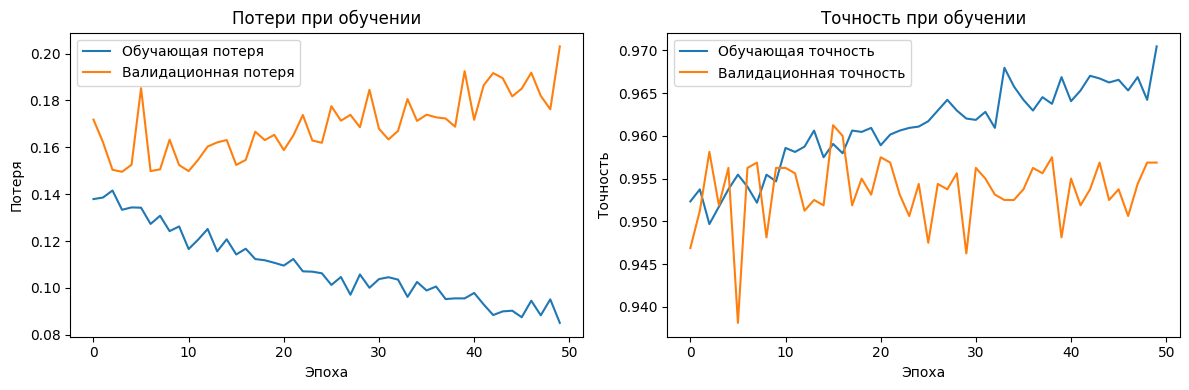

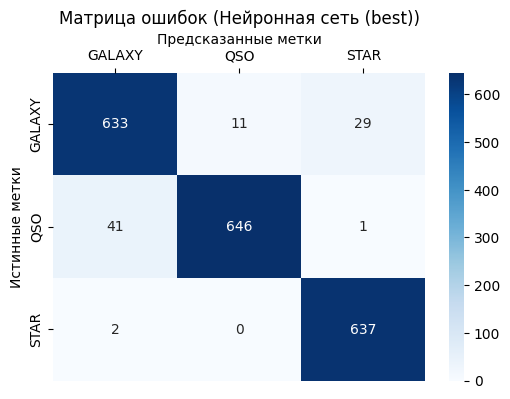

In [199]:
def build_model(hp):
    model = Sequential()

    for i in range(hp.Int('num_layers', 2, 4)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
            activation='relu',
            input_shape=(n_features,) if i == 0 else None
        ))
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)))

    model.add(Dense(n_classes, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

log_path = "C:/nn_tuning_logs"
os.makedirs(log_path, exist_ok=True)

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory=log_path,  
    project_name='nn_tuning'
)

tuner.search(
    X_train_nn, y_train_cat,
    epochs=20,
    validation_split=0.2,
    verbose=1
)

best_model = tuner.get_best_models(num_models=1)[0]

log_dir = "C:/nn_tuning_logs/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir, exist_ok=True)

tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=0
)

history = best_model.fit(
    X_train_nn, 
    y_train_cat, 
    epochs=50, 
    validation_split=0.2,
    callbacks=[tensorboard_callback],  
    verbose=1
)

y_train_pred_nn = best_model.predict(X_train_nn)
y_train_pred_classes = np.argmax(y_train_pred_nn, axis=1)
y_train_proba_nn = y_train_pred_nn

y_test_pred_nn = best_model.predict(X_test_nn)
y_test_pred_classes = np.argmax(y_test_pred_nn, axis=1)
y_test_proba_nn = y_test_pred_nn

print("Нейронная сеть (best)")
calculate_metrics(y_train, y_train_pred_classes, y_train_proba_nn, "обучающего множества")

results.append({
    'Model': 'Нейронная сеть (best)',
    'Dataset': 'Test',
    **calculate_metrics(y_test, y_test_pred_classes, y_test_proba_nn, "тестового множества")

})
print("\nClassification Report (test, best params):")
print(classification_report(y_test, y_test_pred_classes, digits=4))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Обучающая потеря')
plt.plot(history.history['val_loss'], label='Валидационная потеря')
plt.title('Потери при обучении')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Обучающая точность')
plt.plot(history.history['val_accuracy'], label='Валидационная точность')
plt.title('Точность при обучении')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()

plt.tight_layout()
plt.show()


y_test_generic = y_test  
y_pred_generic = y_test_pred_classes 
model_name = "Нейронная сеть (best)" 
label_encoder = le
cm = confusion_matrix(y_test_generic, y_pred_generic)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xticks(rotation=0)  
plt.gca().xaxis.tick_top() 
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title(f'Матрица ошибок ({model_name})')
plt.show()

Модель нейронной сети с параметрами по умолчанию показала высокую производительность, достигнув значений Accuracy, Precision, Recall и F1-score около 95.6% на тестовом множестве и около 96.3% на обучающем, при этом значения AUC составили 0.9904 на тесте — что свидетельствует о превосходной способности модели различать классы. Небольшая разница между метриками на обучающей и тестовой выборках указывает на умеренную склонность к переобучению. <br>

После настройки гиперпараметров наблюдалось изменение в результатах: на тестовом множестве метрики Accuracy, Precision, Recall и F1-score немного снизились примерно до 94.7–94.8%, а значение AUC также уменьшилось (до 0.9891). При этом на обучающем множестве метрики увеличились (до примерно 97%), что согласуется с наблюдаемым на графиках поведением — модель стала более сложной и "запоминающей". Таким образом, в данном случае подбор гиперпараметров, выполненный с текущими настройками, не привел к улучшению обобщающей способности модели на тестовом наборе и, наоборот, ухудшил её по сравнению с моделью по умолчанию. <br>

На графике потерь видно, что обучающая потеря стабильно снижается и достигает очень низкого уровня, тогда как валидационная потеря после начального спада начинает колебаться и даже растёт в конце обучения — это классический признак переобучения. Аналогичная картина наблюдается и на графике точности: обучающая точность почти достигает 1.0 и продолжает расти, а валидационная точность демонстрирует шумный характер, нестабильность и даже падение в последние эпохи. Это говорит о том, что настроенная модель слишком сильно адаптировалась к обучающим данным, теряя способность обобщать новые. <br>

25. TensorBoard

![alt text](image.png)

График смещений (bias) показывает распределение значений смещений (bias) по слоям и по эпохам. Смещения сосредоточены в узком диапазоне от -0.25 до 0.19.
Распределение имеет один пик, что говорит о стабильности обучения.Разные линии (слои или эпохи) перекрываются — это признак того, что смещения во всех слоях ведут себя схоже, нет аномалий.

![alt text](image-1.png)

Графики точности на обучающей и валидационной выборках показывают динамику точности (accuracy) по эпохам. Обучающая точность (тёмно-синяя) растёт и стабилизируется на уровне 0.97. Валидационная точность (голубая) колеблется около 0.95–0.96, но не растёт выше обучающей, что хорошо — признак отсутствия переобучения.

![alt text](image-2.png)

Графики потерь на обучающей и валидационной выборках показывают динамику функций потерь (categorical_crossentropy) по эпохам. Обучающая потеря (тёмно-синяя) плавно снижается примерно до 0.07. Валидационная потеря (голубая) стабилизируется на уровне 0.18 — выше обучающей, что нормально. К концу обучения валидационная потеря не растёт — это ключевой признак отсутствия переобучения.

26. Сравнение всех методов

                       Model Dataset  Accuracy  Precision (macro)  \
0       GaussianNB (default)    Test    0.9245           0.925564   
1          GaussianNB (best)    Test    0.9265           0.927406   
2      BernoulliNB (default)    Test    0.6530           0.651695   
3         BernoulliNB (best)    Test    0.6690           0.677561   
4   Дерево решений (default)    Test    0.9545           0.955399   
5      Дерево решений (best)    Test    0.9635           0.964155   
6              LDA (default)    Test    0.7845           0.792461   
7                 LDA (best)    Test    0.7845           0.792461   
8              SVM (default)    Test    0.9240           0.925393   
9                 SVM (best)    Test    0.9540           0.954574   
10            k-NN (default)    Test    0.8510           0.855329   
11               k-NN (best)    Test    0.8800           0.882845   
12  Нейронная сеть (default)    Test    0.9565           0.957317   
13     Нейронная сеть (best)    Te

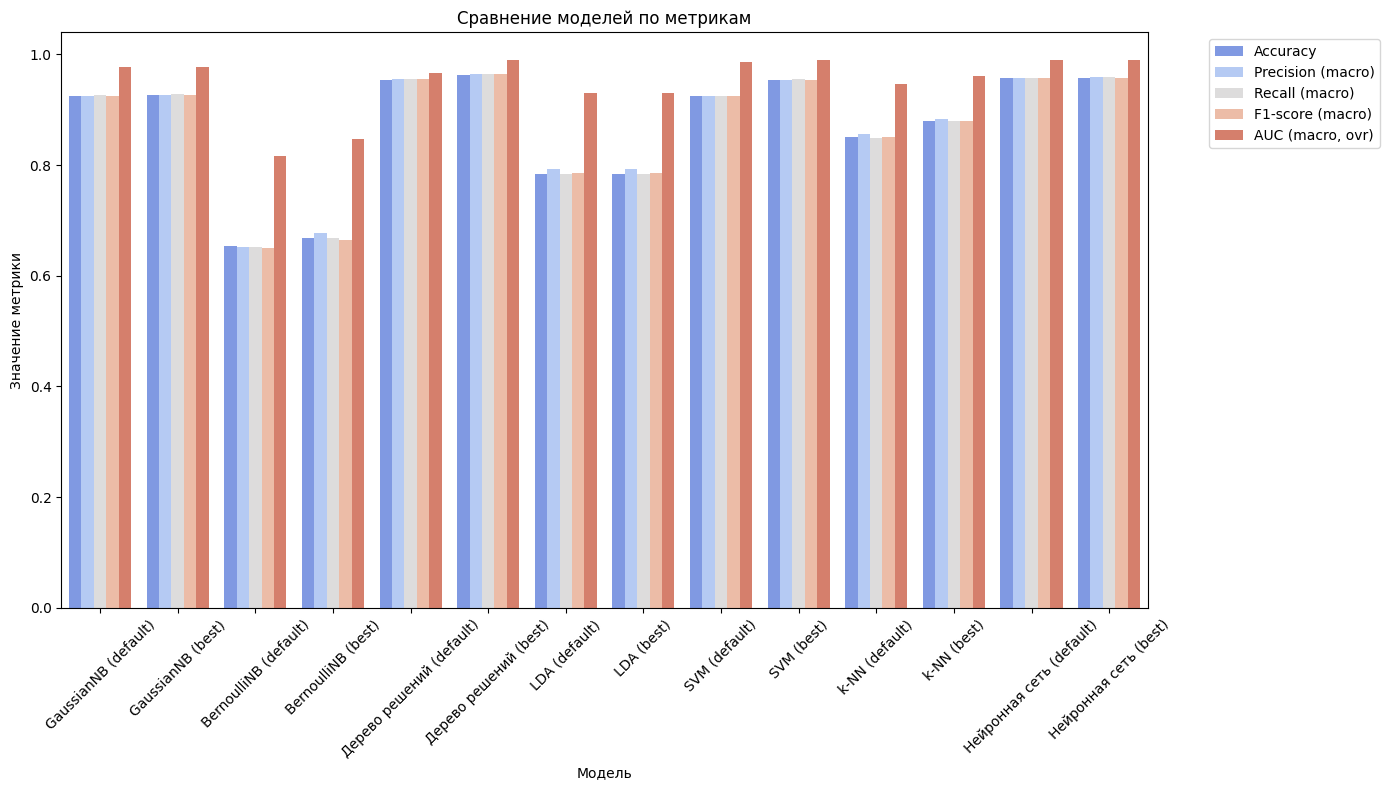

In [200]:
results_df = pd.DataFrame(results)
print(results_df)

metrics_cols = ['Accuracy', 'Precision (macro)', 'Recall (macro)', 
                'F1-score (macro)', 'AUC (macro, ovr)']
plot_data = results_df[['Model'] + metrics_cols].copy()

plot_data_long = plot_data.melt(id_vars='Model', value_vars=metrics_cols,
                                var_name='Metric', value_name='Score')

plt.figure(figsize=(14, 8))
sns.barplot(data=plot_data_long, x='Model', y='Score', hue='Metric', palette='coolwarm')
plt.title('Сравнение моделей по метрикам')
plt.xlabel('Модель')
plt.ylabel('Значение метрики')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

В ходе лабораторной работы были реализованы различные модели для решения задачи классификации. По итогам оценки всех моделей, лучшую общую производительность на тестовом множестве показали настроенные ("best") модели SVM и Дерево решений, достигнув Accuracy около 95.4% - 96.35% и высоких значений других метрик (Precision, Recall, F1-score, AUC). Также высокие результаты продемонстрировала нейронная сеть с гиперпараметрами по умолчанию (Accuracy 95.6%). Модели GaussianNB и k-NN также показали хорошие, но немного более низкие результаты (около 92% - 88% соответственно). Модель LDA оказалась наименее эффективной среди рассмотренных (Accuracy около 78.45%). Подбор гиперпараметров с помощью GridSearchCV улучшил результаты для большинства моделей, таких как GaussianNB, BernoulliNB, SVM, k-NN и Дерево решений, но не дал положительного эффекта для LDA и, как показал анализ графиков, привёл к переобучению и снижению качества для нейронной сети. 